In [1]:
import glob, os, re, sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d, CubicSpline
from scipy.integrate import quad
import scienceplots
from classy import Class
import warnings
import pk_analysis as pka
import pickle

plt.style.use(['science', 'no-latex'])
plt.rcParams.update({
    'figure.figsize': (6, 4),       # or (7, 4.5) for a bit more room
    'figure.dpi': 200,              # higher DPI for crisp display
    'savefig.dpi': 300,             # good for printing/export
    'lines.linewidth': 1.5,         # make lines less thin
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
})

In [2]:
lcdm_pars = {
    # Reference Cosmology from EuclidEmuII
    'H0'      : 67,
    'Omega_b' : 0.049,
    'Omega_cdm' : '0.27 - Omega_ncdm',

    'A_s' : 2.1e-9,
    'n_s' : 0.96,
    'alpha_s' : 0,
    'k_pivot' : 0.05,

    'N_ur' : 0,
    'N_ncdm' : 1,
    'deg_ncdm' : 3,
    'm_ncdm' : 0.058/3,

    'evolver': 0,
    'output': 'mPk',
    'P_k_max_1/Mpc': 3.0,
    'z_max_pk': 49
}

nkgb_pars = {
    # Hi-CLASS
    'Omega_Lambda': 0,
    'Omega_fld': 0,
    'Omega_smg': -1,
    'gravity_model': 'nkgb',
    'parameters_smg': '4e-05,  2,  0',
    # NEUTRINOS
    # Disable massless neutrinos
    'N_ur': 0,
    # Add 3 massive neutrinos of equal mass    
    'N_ncdm'  : 1,
    'deg_ncdm': 3,
    'm_ncdm'  : max(0.058/3, 1e-100), # avoid exact value of 0.0
    #NON LINEAR NEUTRINOS
    'l_max_ncdm'              : 200,
    'Number of momentum bins' : 50,
    'Quadrature strategy'     : 2,
    'ncdm_fluid_approximation': 3,
    # CLASS evolver
    'evolver': 0,
    'output': 'mPk',
    'P_k_max_1/Mpc': 3.0,
    'z_max_pk': 49
}
gal3_pars = {
    # Hi-CLASS
    'Omega_Lambda': 0,
    'Omega_fld': 0,
    'Omega_smg': -1,
    'gravity_model': 'galileon',
    'gravity_submodel': 'cubic',
    # NEUTRINOS
    # Disable massless neutrinos
    'N_ur': 0,
    # Add 3 massive neutrinos of equal mass    
    'N_ncdm'  : 1,
    'deg_ncdm': 3,
    'm_ncdm'  : max(0.058/3, 1e-100), # avoid exact value of 0.0
    #NON LINEAR NEUTRINOS
    'l_max_ncdm'              : 200,
    'Number of momentum bins' : 50,
    'Quadrature strategy'     : 2,
    'ncdm_fluid_approximation': 3,
    # CLASS evolver
    'evolver': 0,
    'output': 'mPk',
    'P_k_max_1/Mpc': 3.0,
    'z_max_pk': 49
}

gal4_pars = {
    # Hi-CLASS
    'Omega_Lambda': 0,
    'Omega_fld': 0,
    'Omega_smg': -1,
    'gravity_model': 'galileon',
    'gravity_submodel': 'quartic',
    'parameters_smg': '2.43', # xi  
    # NEUTRINOS
    # Disable massless neutrinos
    'N_ur': 0,
    # Add 3 massive neutrinos of equal mass    
    'N_ncdm'  : 1,
    'deg_ncdm': 3,
    'm_ncdm'  : max(0.058/3, 1e-100), # avoid exact value of 0.0
    #NON LINEAR NEUTRINOS
    'l_max_ncdm'              : 200,
    'Number of momentum bins' : 50,
    'Quadrature strategy'     : 2,
    'ncdm_fluid_approximation': 3,
    # CLASS evolver
    'evolver': 0,
    'output': 'mPk',
    'P_k_max_1/Mpc': 3.0,
    'z_max_pk': 49
}
gal5_pars = {
    # Hi-CLASS
    'Omega_Lambda': 0,
    'Omega_fld': 0,
    'Omega_smg': -1,
    'gravity_model': 'galileon',
    'gravity_submodel': 'quintic',
    'parameters_smg': '2.43, -0.132',  # xi, c3
    # NEUTRINOS
    # Disable massless neutrinos
    'N_ur': 0,
    # Add 3 massive neutrinos of equal mass    
    'N_ncdm'  : 1,
    'deg_ncdm': 3,
    'm_ncdm'  : max(0.058/3, 1e-100), # avoid exact value of 0.0
    #NON LINEAR NEUTRINOS
    'l_max_ncdm'              : 200,
    'Number of momentum bins' : 50,
    'Quadrature strategy'     : 2,
    'ncdm_fluid_approximation': 3,
    # CLASS evolver
    'evolver': 0,
    'output': 'mPk',
    'P_k_max_1/Mpc': 3.0,
    'z_max_pk': 49
}

In [3]:
local = pka.PowerSpectrumAnalyzer()
leftraru = pka.PowerSpectrumAnalyzer('/home/vpedre/mochi_CONCEPT/leftraru_output/hiLCDM')

In [4]:
scales = np.array([0.02, 0.25, 0.29, 0.33, 0.4, 0.5, 0.67, 1.])

In [5]:
# class_curves = {
#     'Lambda': local.class_pk(class_pars=lcdm_pars),
#     'nKGB': local.class_pk(class_pars=nkgb_pars),
#     'gal3': local.class_pk(class_pars=gal3_pars),
#     'gal4': local.class_pk(class_pars=gal4_pars),
#     'gal5': local.class_pk(class_pars=gal5_pars)
# }

# with open("class_curves.pkl", "wb") as f:
#     pickle.dump(class_curves, f)

In [5]:
with open("class_curves.pkl", "rb") as f:
    class_curves = pickle.load(f)

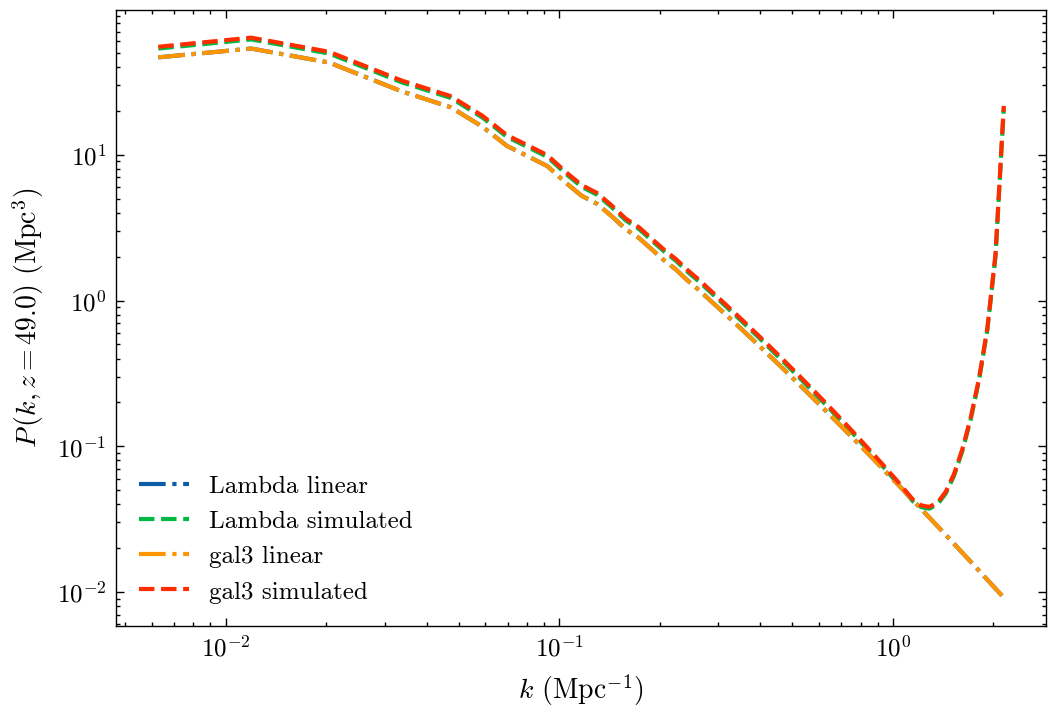

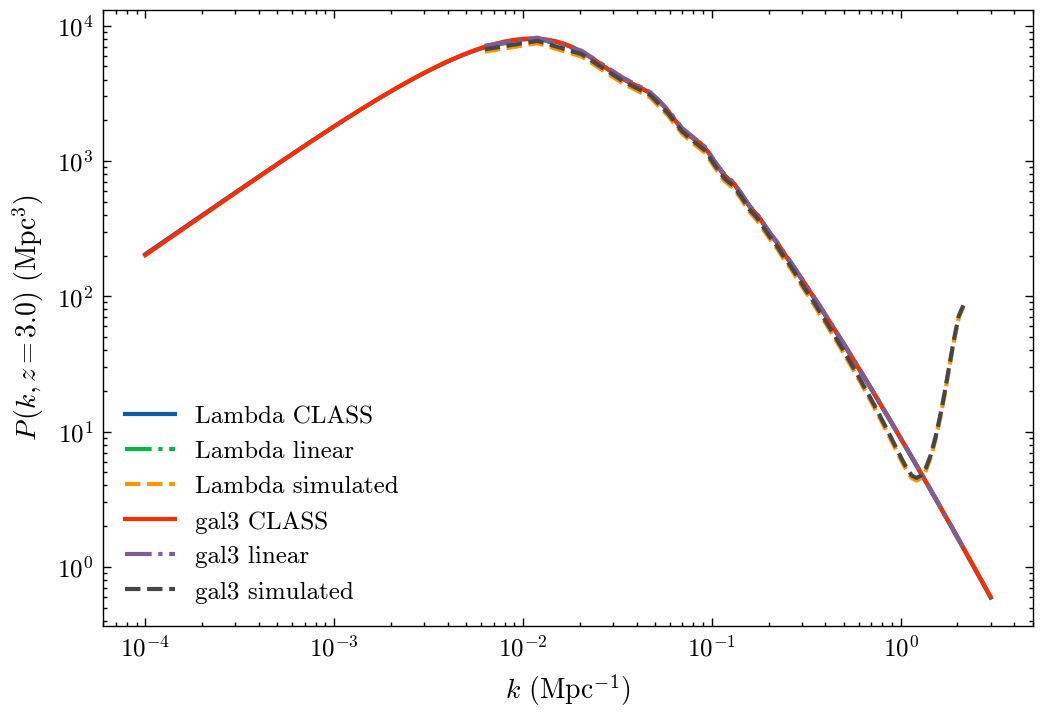

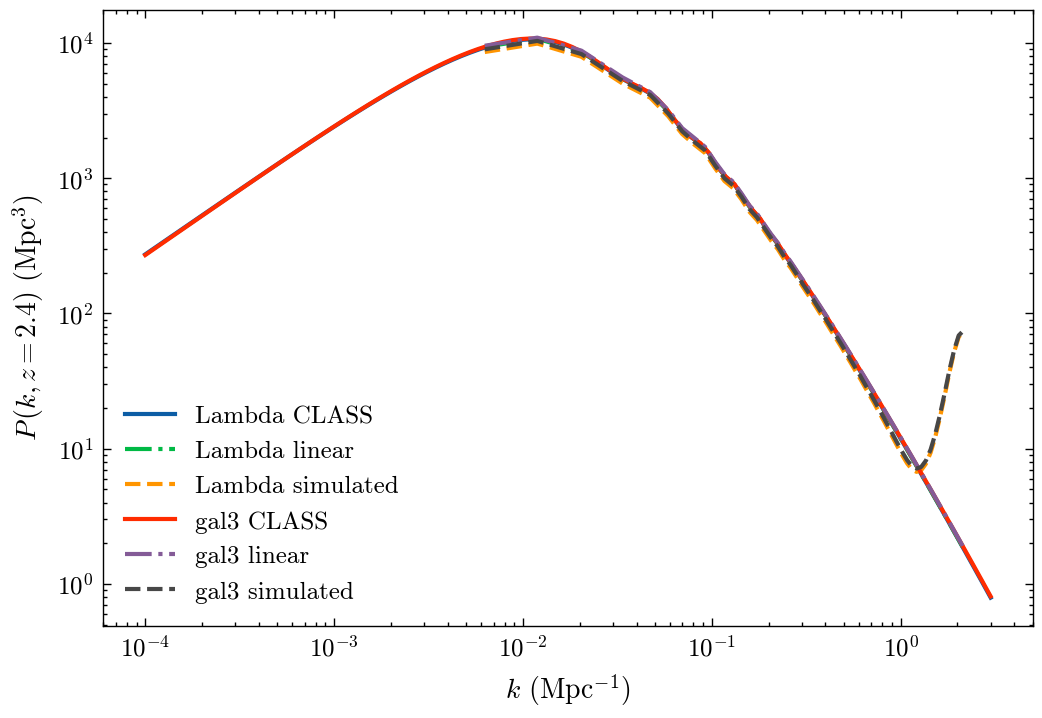

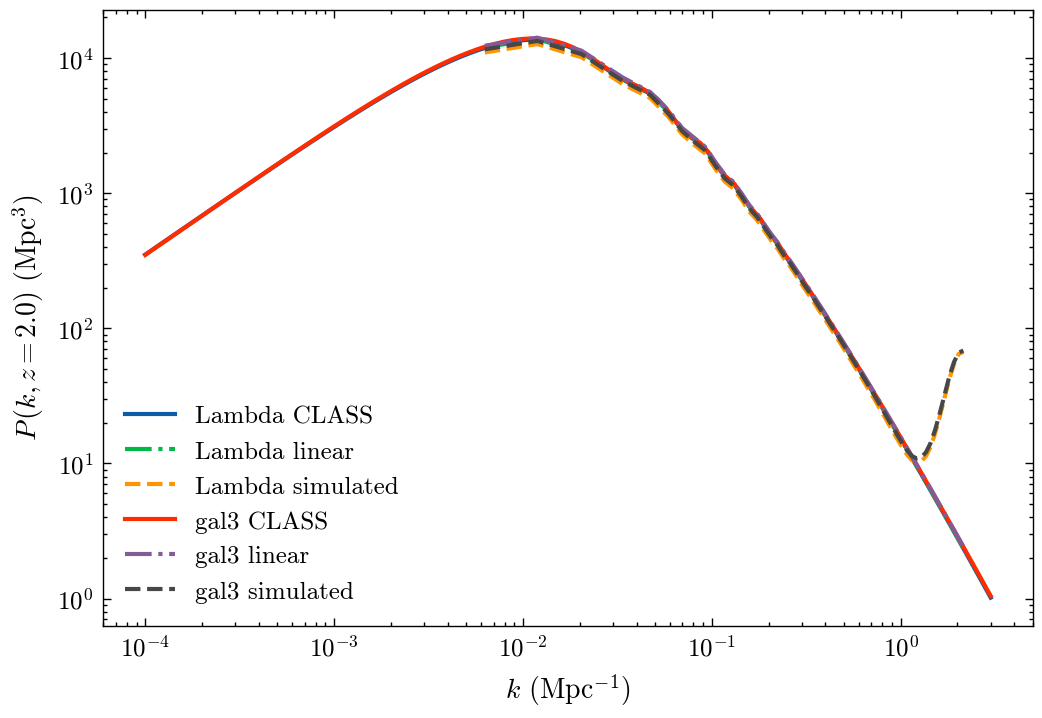

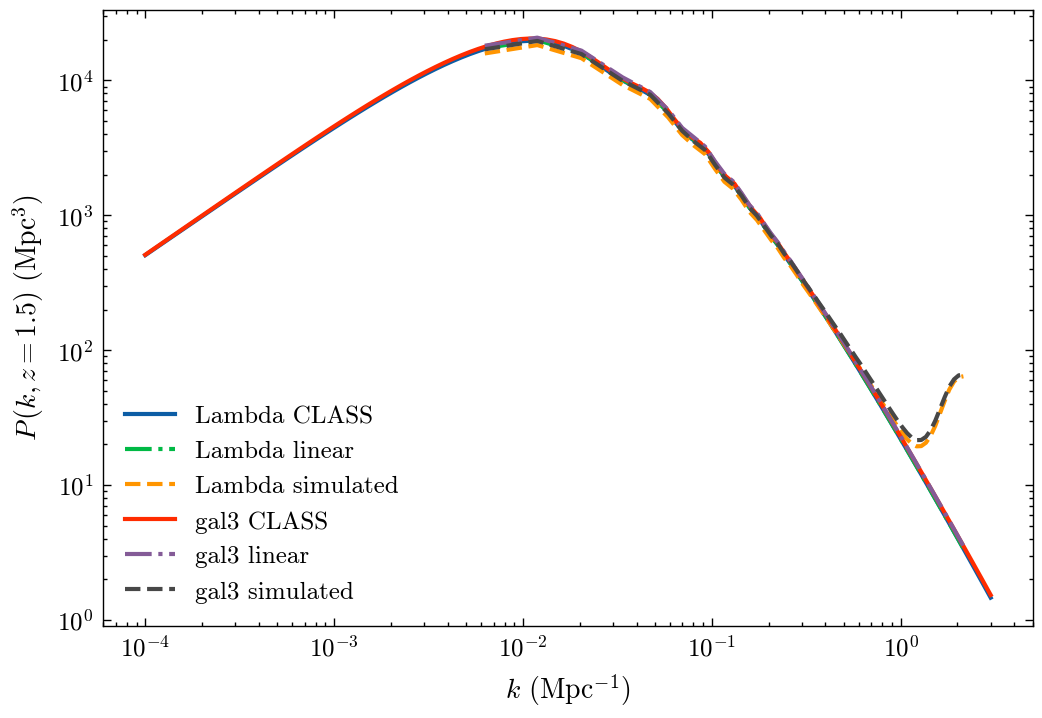

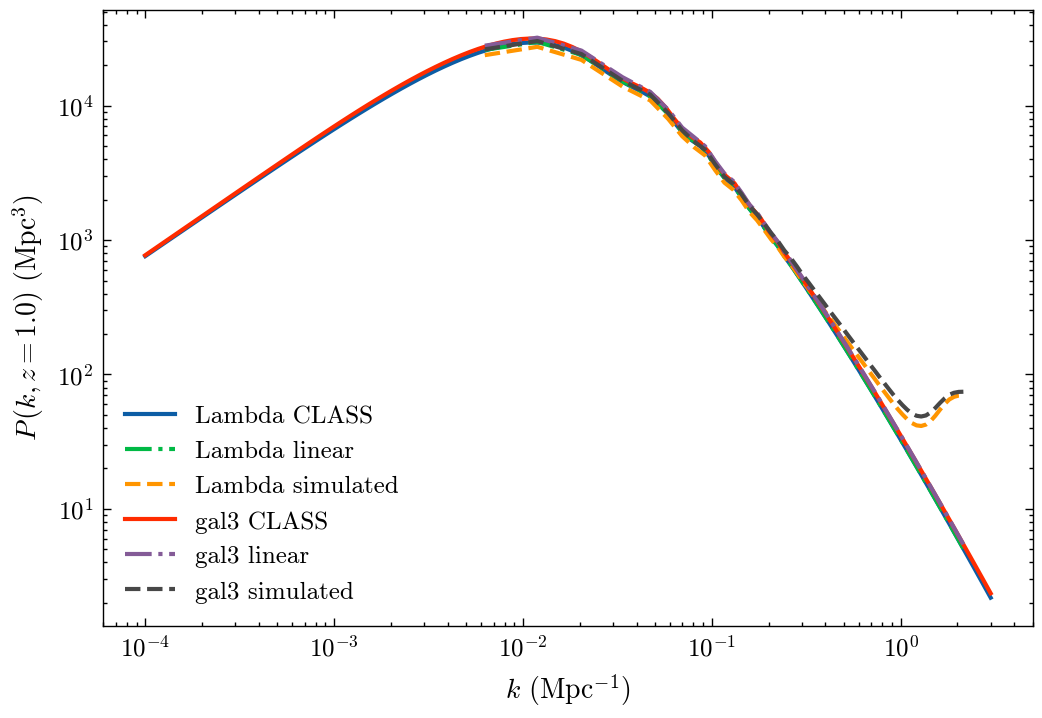

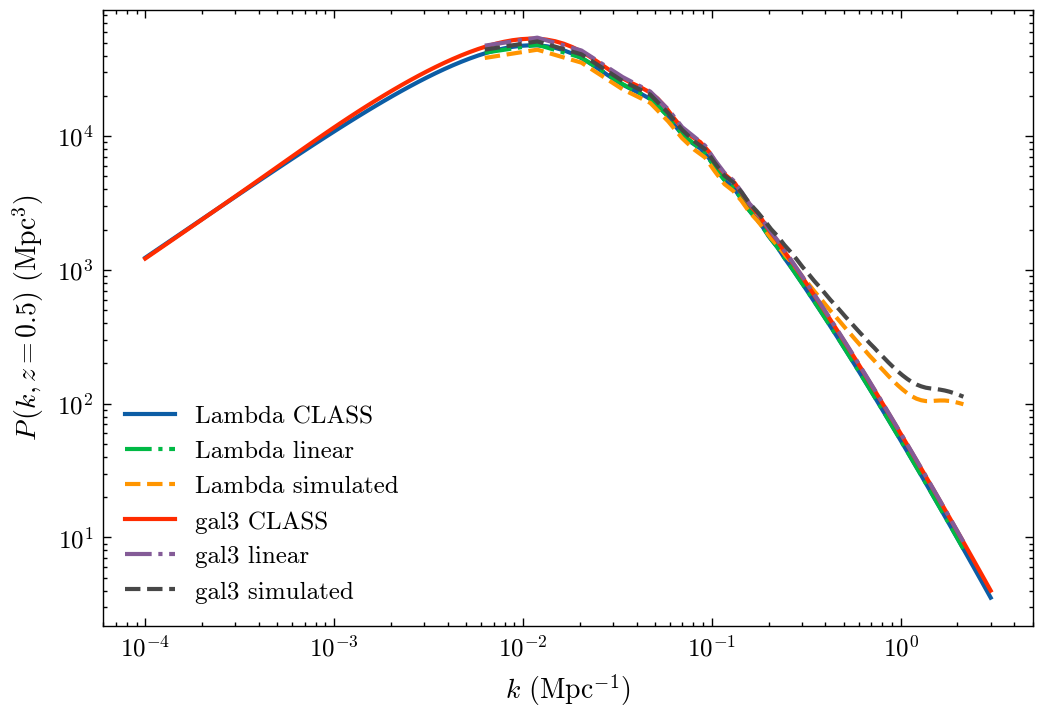

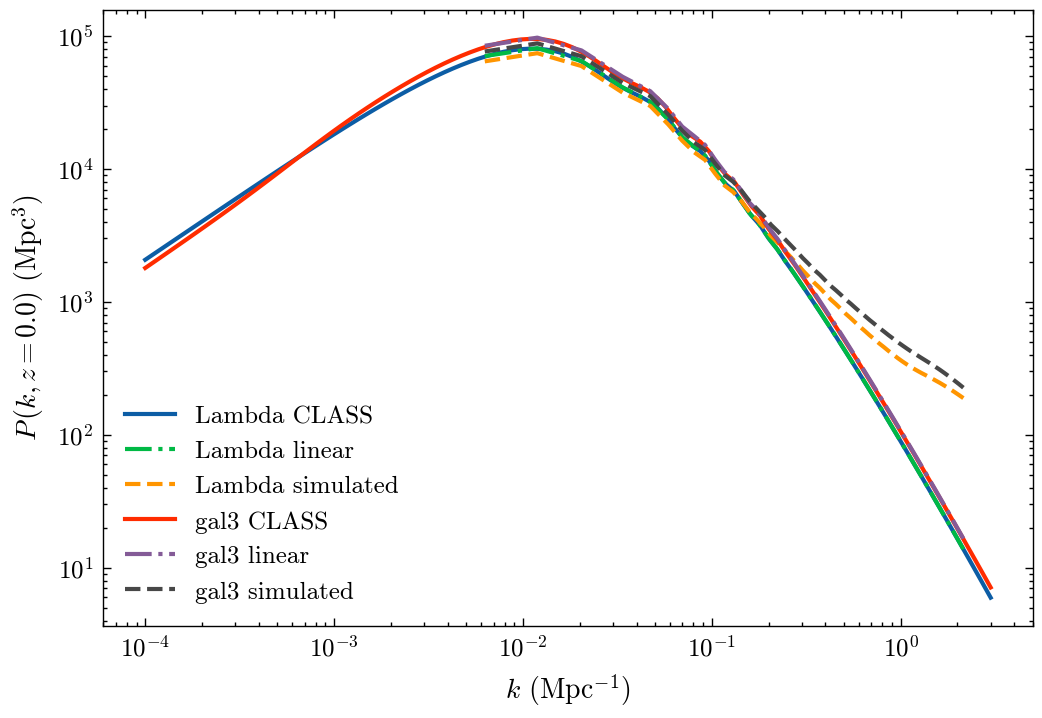

In [6]:
for a in scales: 
    # local.plot_Pk(models=['Lambda', 'nKGB'], scale_factor=a, norm='read')
    local.plot_Pk(models=['Lambda', 'gal3'], scale_factor=a, norm='read', class_curves=class_curves)

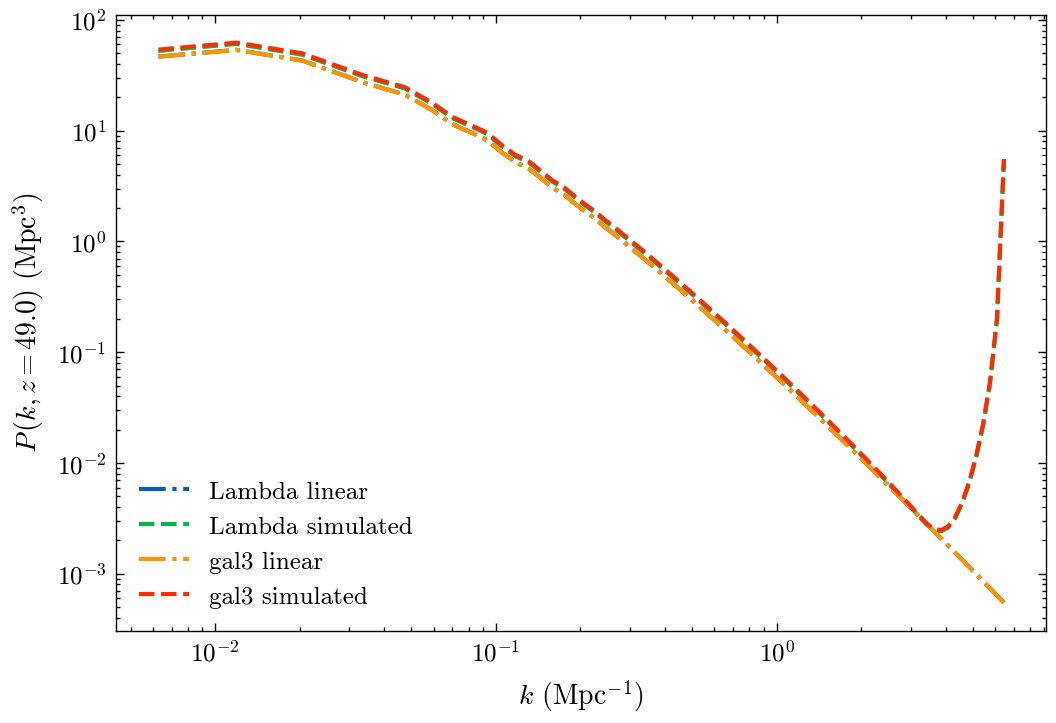

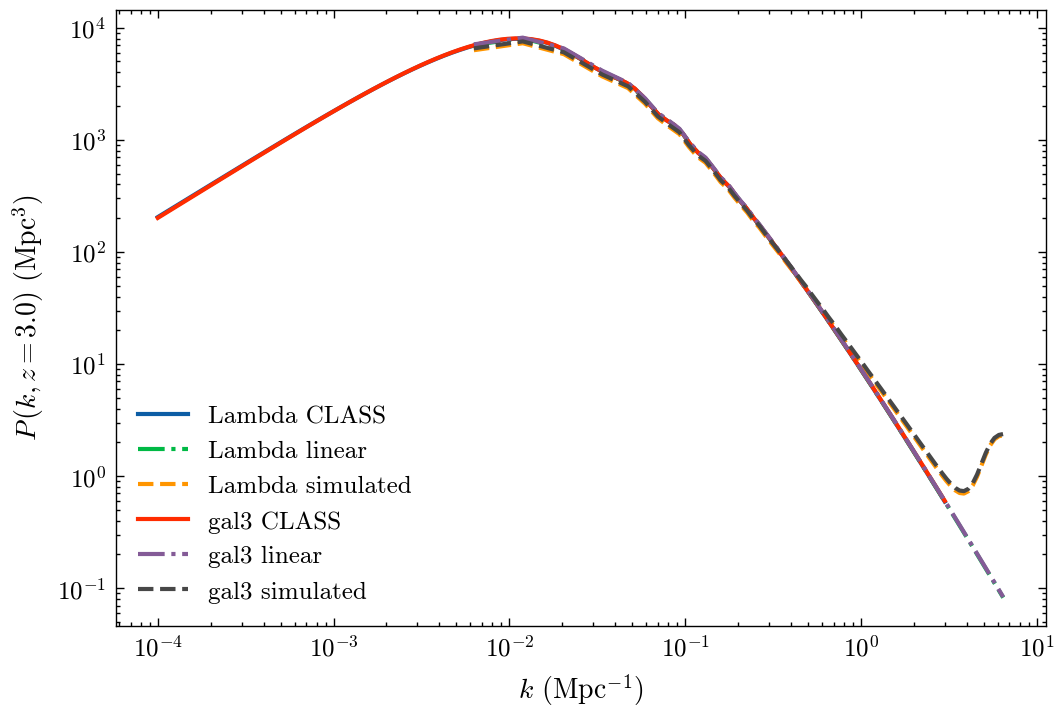

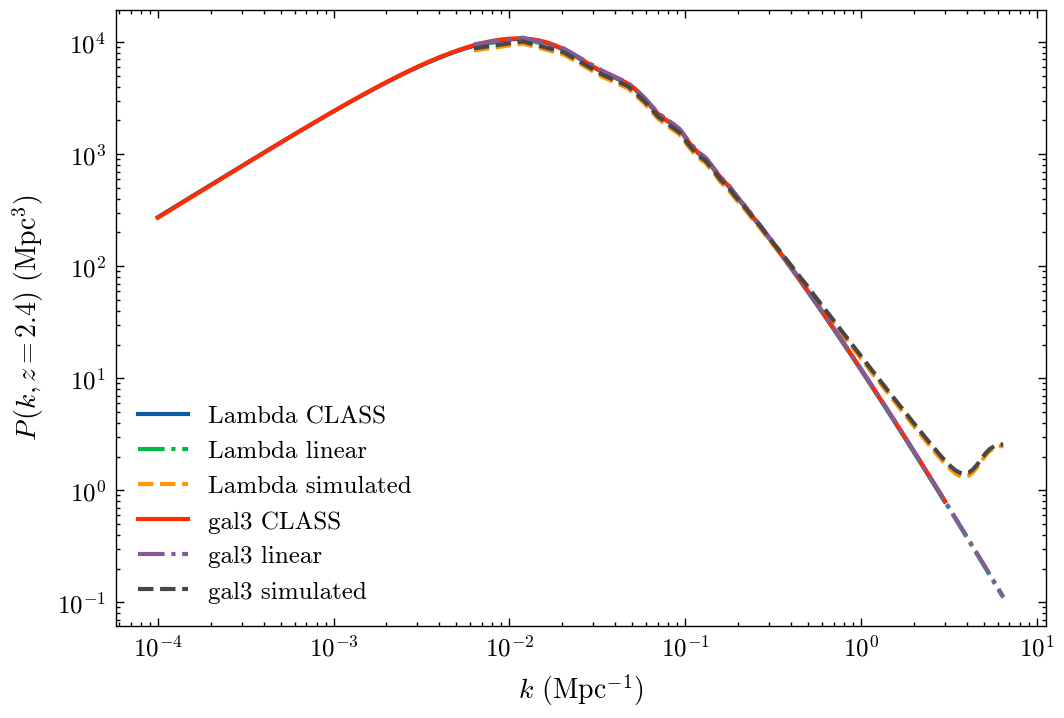

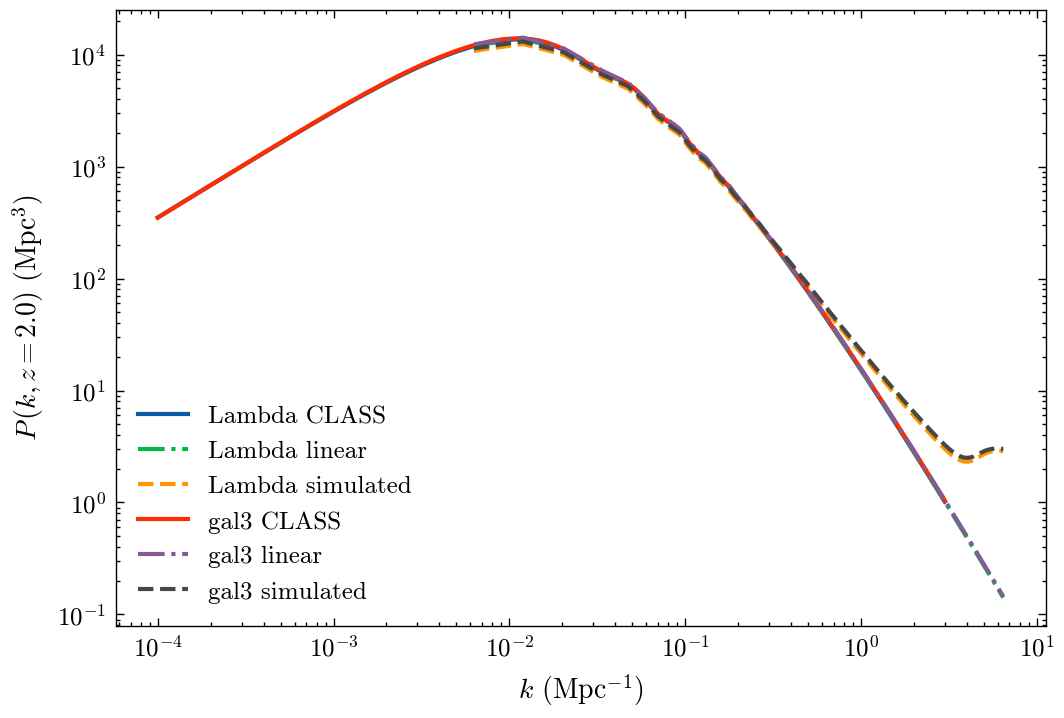

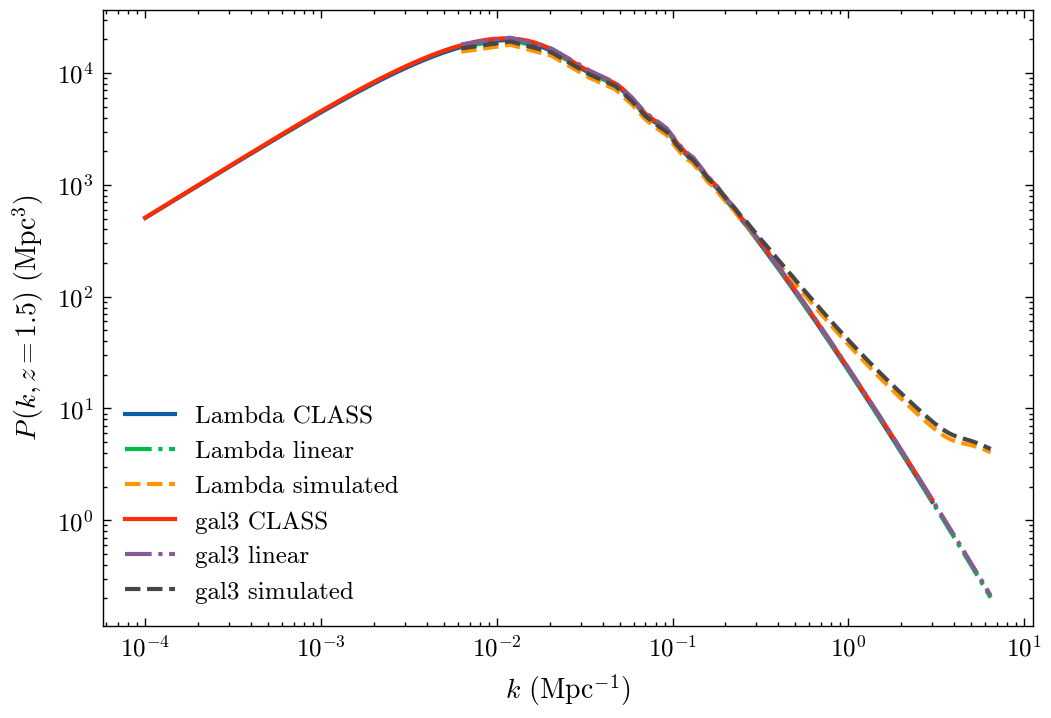

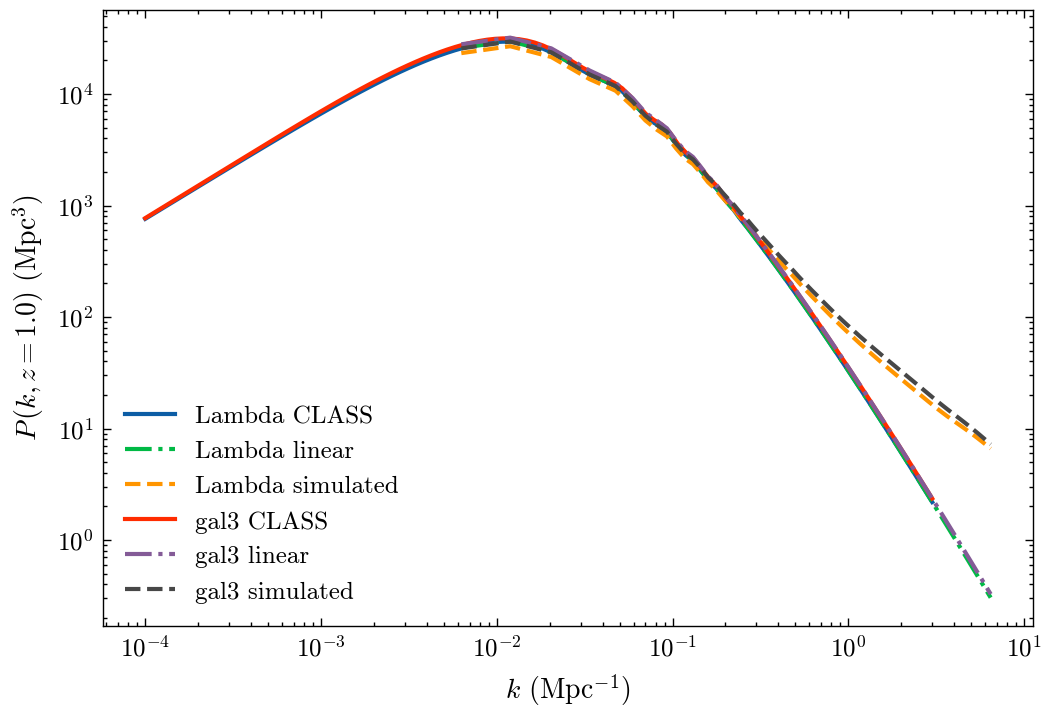

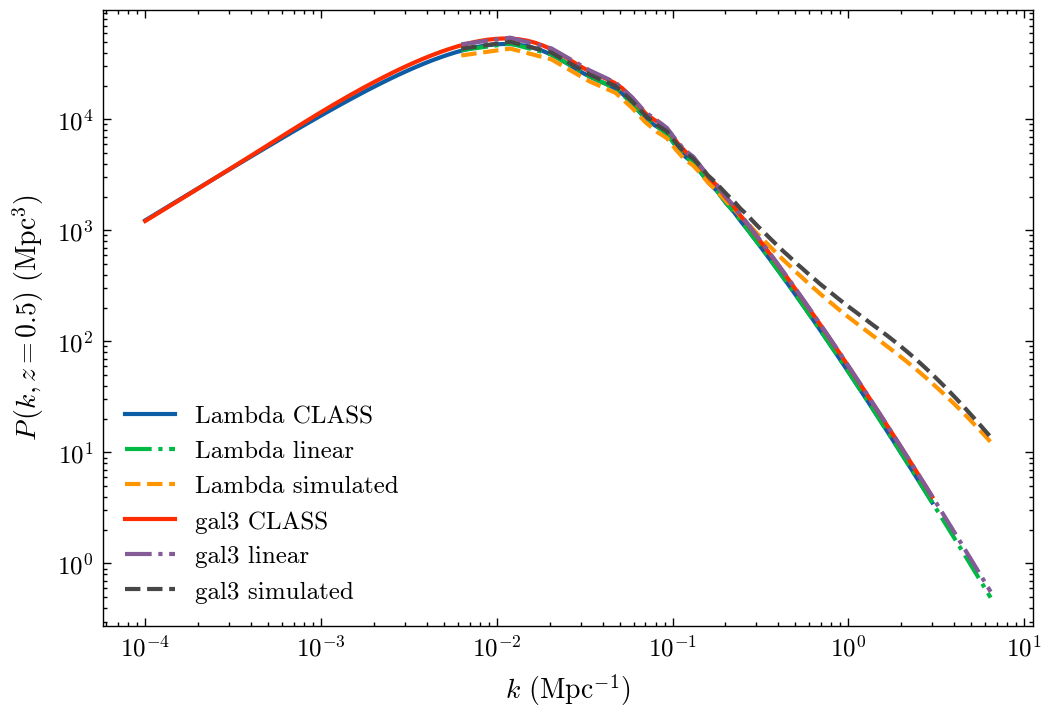

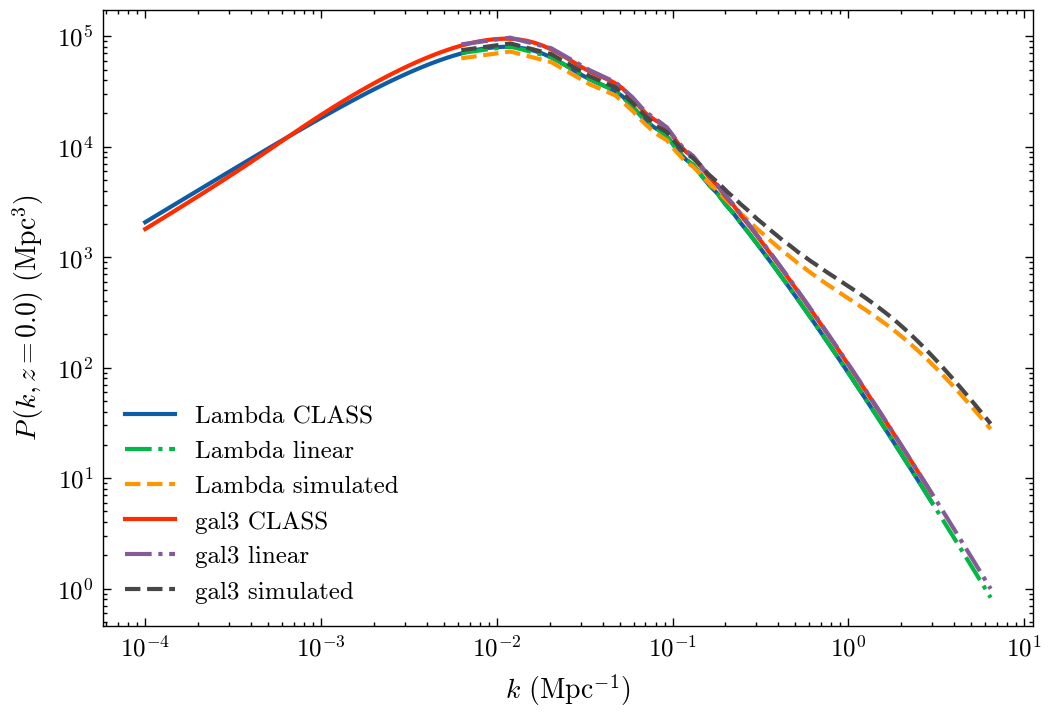

In [8]:
for a in scales: 
    # local.plot_Pk(models=['Lambda', 'nKGB'], scale_factor=a, norm='read')
    leftraru.plot_Pk(models=['Lambda', 'gal3'], scale_factor=a, norm='read', class_curves=class_curves)

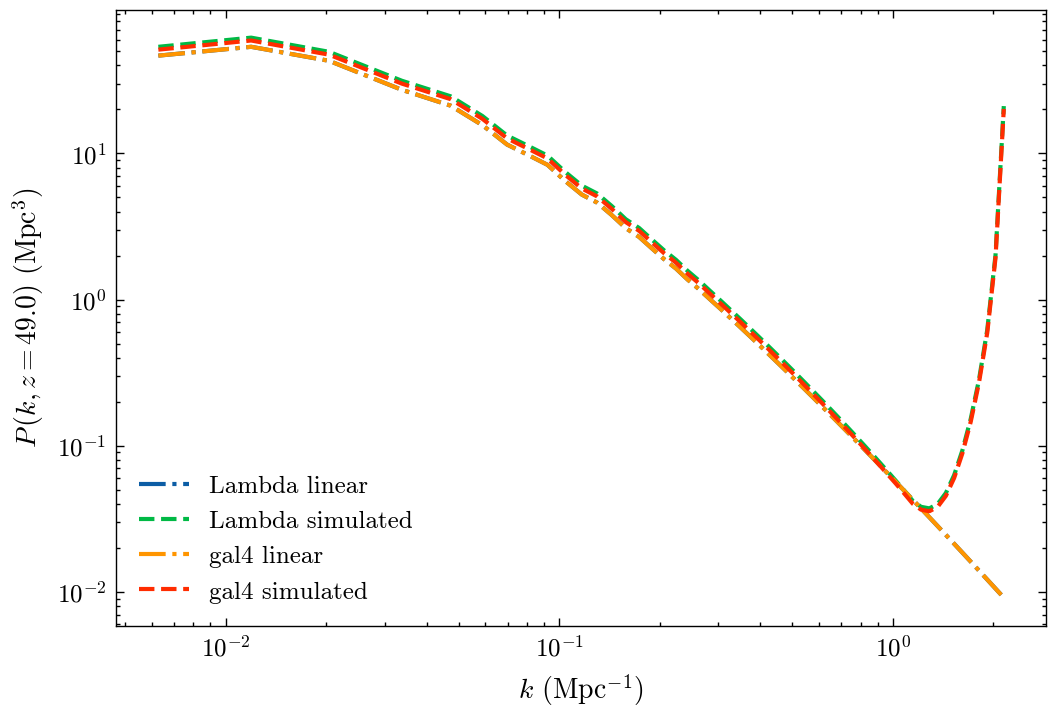

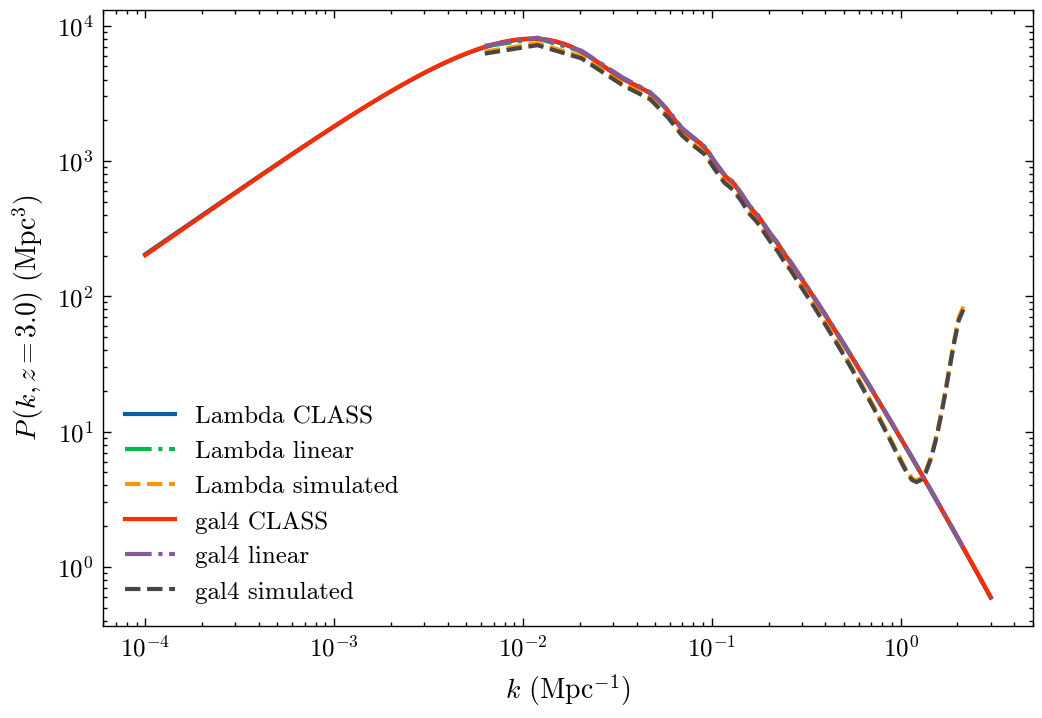

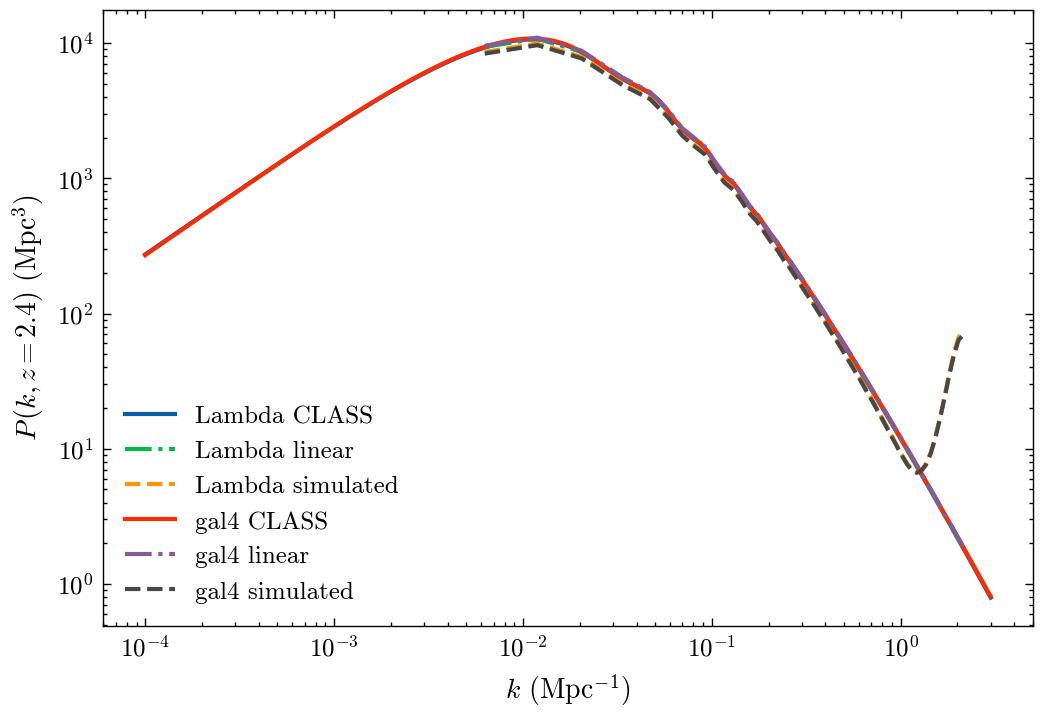

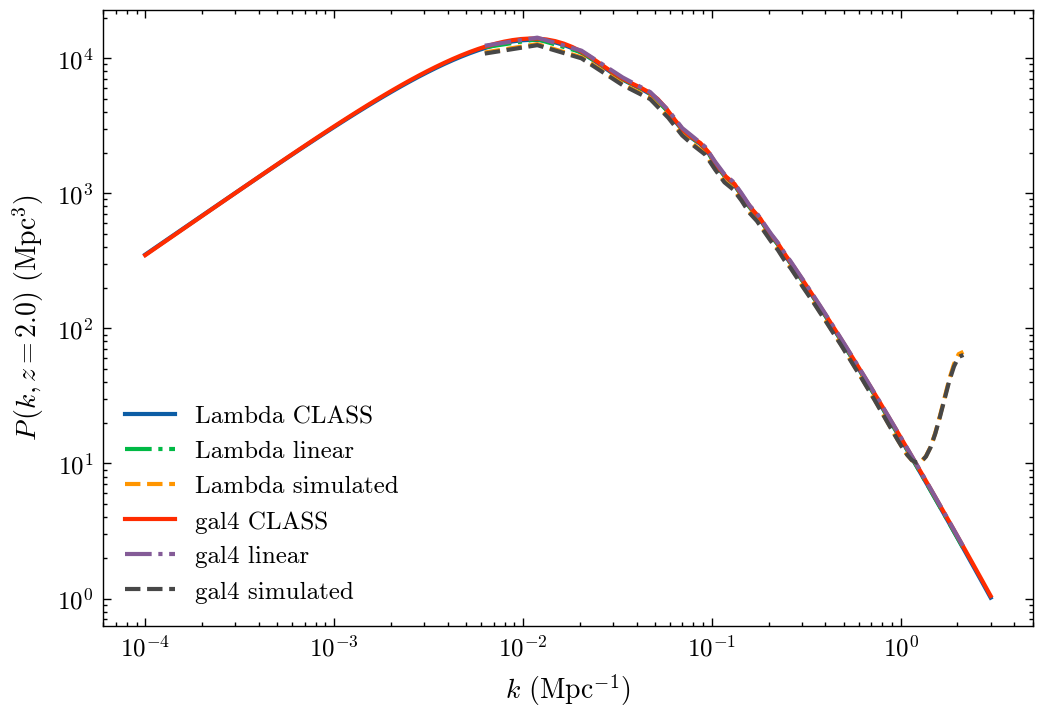

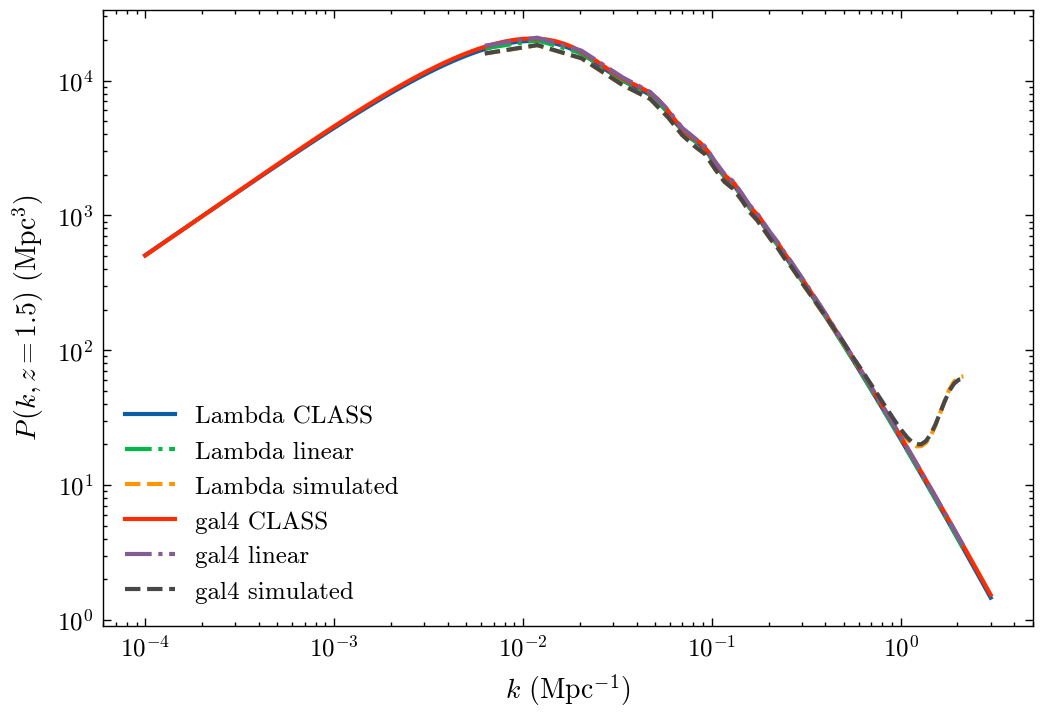

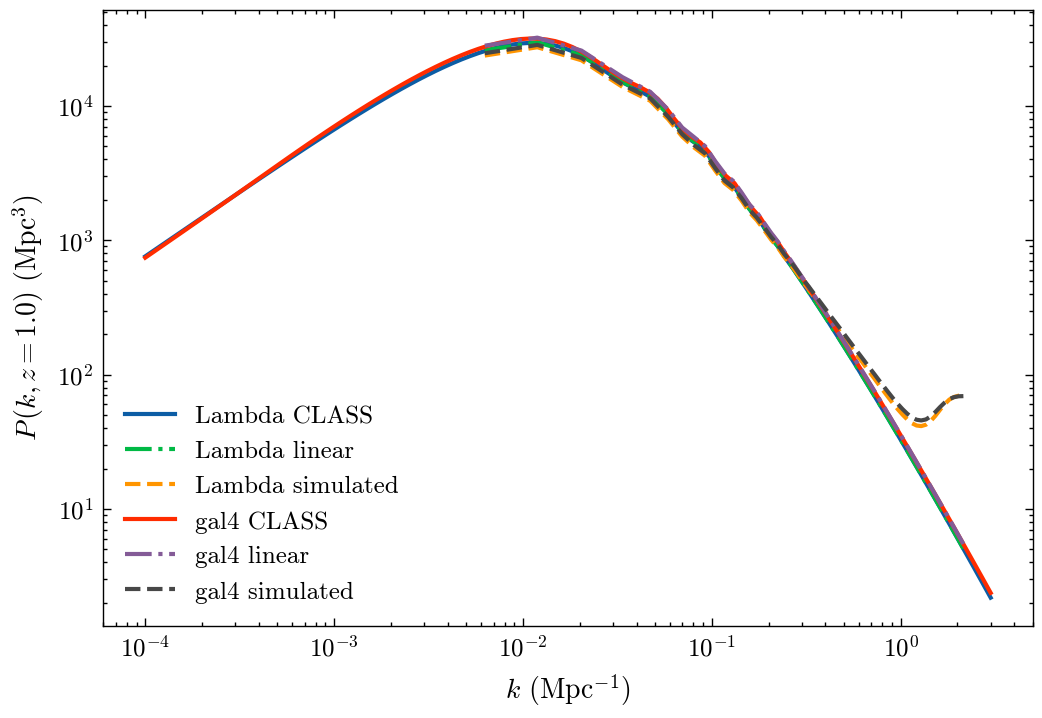

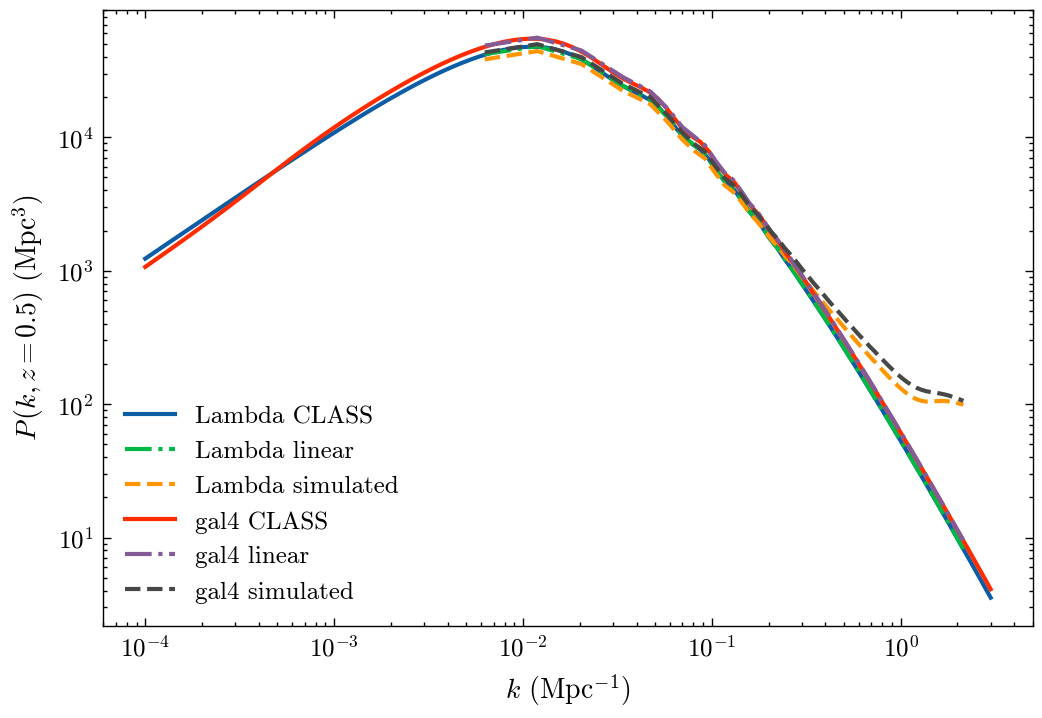

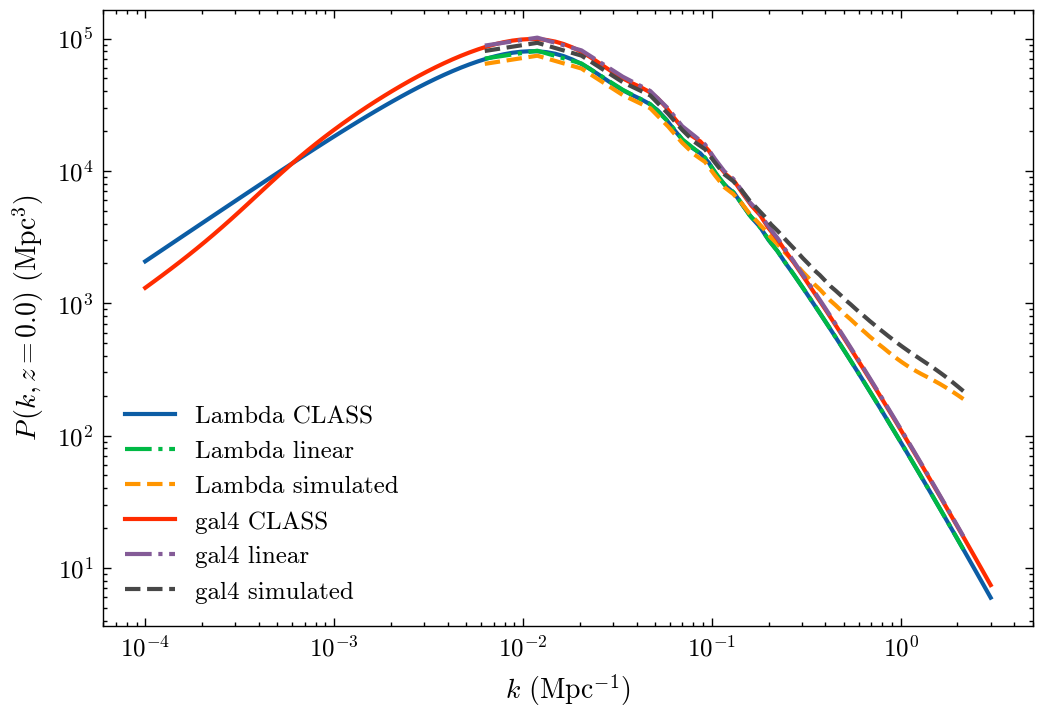

In [9]:
for a in scales: 
    # local.plot_Pk(models=['Lambda', 'nKGB'], scale_factor=a, norm='read')
    local.plot_Pk(models=['Lambda', 'gal4'], scale_factor=a, norm='read', class_curves=class_curves)

KeyError: ('gal5', 'a=1.00')

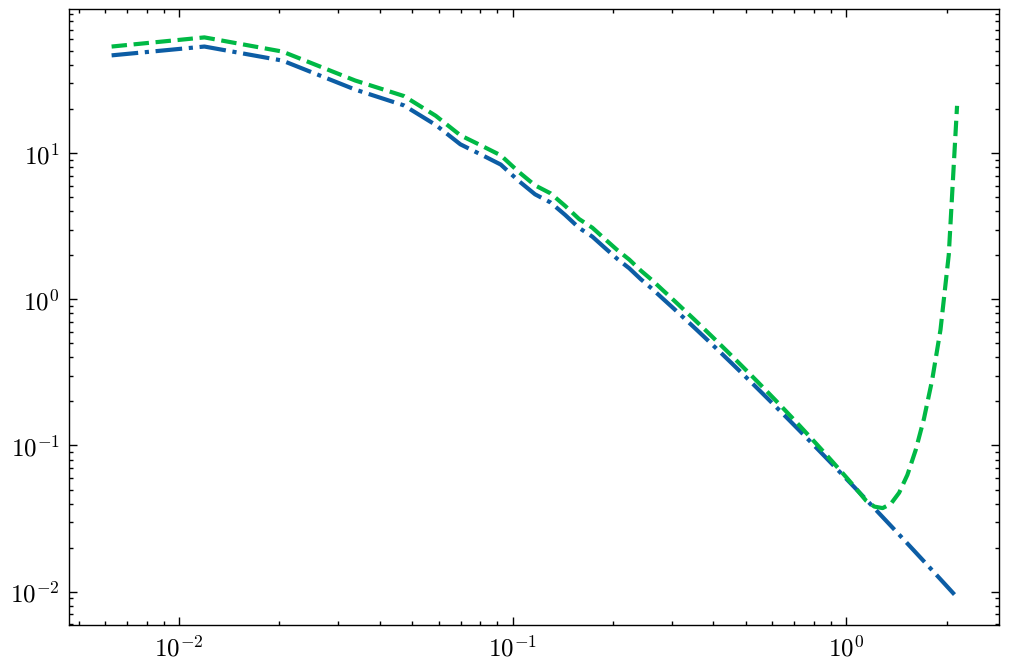

In [10]:
for a in scales: 
    # local.plot_Pk(models=['Lambda', 'nKGB'], scale_factor=a, norm='read')
    local.plot_Pk(models=['Lambda', 'gal5'], scale_factor=a, norm='read', class_curves=class_curves)

In [ ]:
hi_class = PowerSpectrumAnalyzer(data_dir='/home/vpedre/concept_basem')
mochi_class = PowerSpectrumAnalyzer()

hi_class._read_data()
mochi_class._read_data()

({('hiLambda',
   'a=0.02'): array([0.00628319, 0.01192201, 0.02138152, 0.03426211, 0.04759575,
         0.05954689, 0.07074689, 0.08205666, 0.09378063, 0.105939  ,
         0.11871516, 0.13225759, 0.14649596, 0.16122434, 0.17671324,
         0.1932288 , 0.21047843, 0.22861293, 0.24766256, 0.26758276,
         0.28848645, 0.31039332, 0.33334515, 0.35734267, 0.38248601,
         0.40879294, 0.43630517, 0.46503932, 0.49505545, 0.52643784,
         0.55915117, 0.59326137, 0.62886024, 0.66618158, 0.70561287,
         0.74735927, 0.79155636, 0.8383567 , 0.88790792, 0.94040417,
         0.99602444, 1.0549279 , 1.1172937 , 1.1833685 , 1.253334  ,
         1.3274337 , 1.4059275 , 1.4890508 , 1.5770761 , 1.6703278 ,
         1.7691055 , 1.8737036 , 1.9844814 , 2.1018825 ]),
  ('hiLambda',
   'a=0.25'): array([0.00628319, 0.01192201, 0.02138152, 0.03426211, 0.04759575,
         0.05954689, 0.07074689, 0.08205666, 0.09378063, 0.105939  ,
         0.11871516, 0.13225759, 0.14649596, 0.16122434, 0.

In [ ]:
model = 'Lambda'

ks, P_c, P_l, s8_c, s8_l = {}, {}, {}, {}, {}


ks['hiclass'] = hi_class._read_data()[0][model, 'a=1.00']
P_c['hiclass']  = hi_class._read_data()[1][model, 'a=1.00']
P_l['hiclass']  = hi_class._read_data()[2][model, 'a=1.00']
s8_c['hiclass']  = hi_class._read_data()[3][model, 'a=1.00']
s8_l['hiclass']  = hi_class._read_data()[4][model, 'a=1.00']

ks['mochiclass'] = mochi_class._read_data()[0][model, 'a=1.00']
P_c['mochiclass']  = mochi_class._read_data()[1][model, 'a=1.00']
P_l['mochiclass']  = mochi_class._read_data()[2][model, 'a=1.00']
s8_c['mochiclass']  = mochi_class._read_data()[3][model, 'a=1.00']
s8_l['mochiclass']  = mochi_class._read_data()[4][model, 'a=1.00']


KeyError: ('Lambda', 'a=1.00')

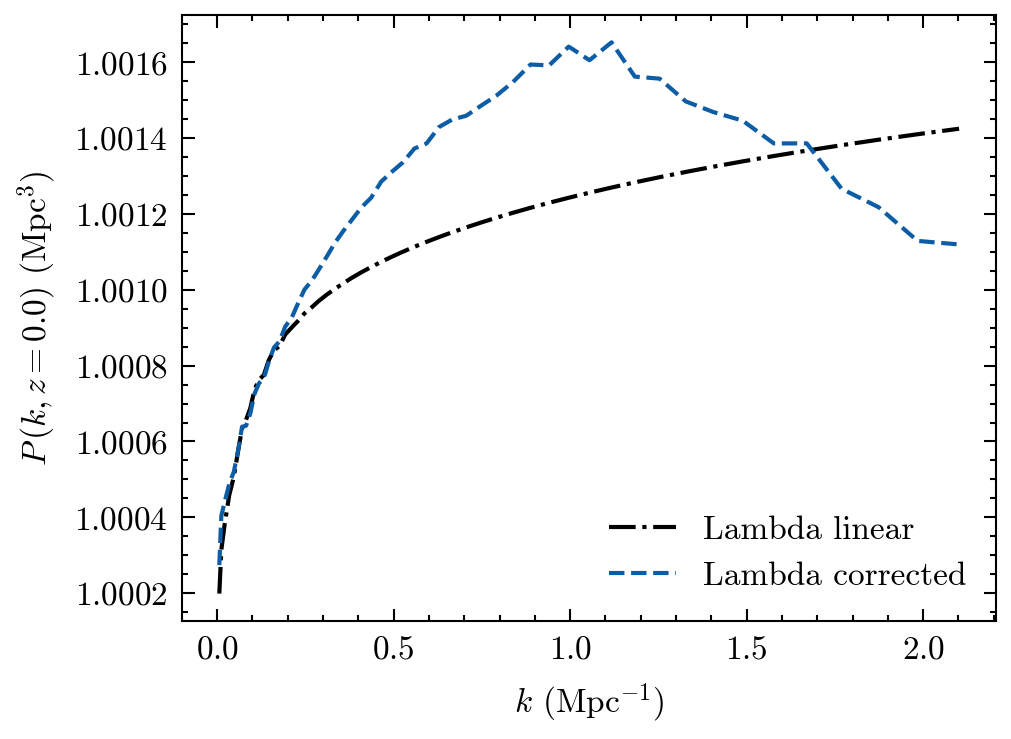

In [ ]:
scale_factor = 1

fig, ax = plt.subplots()
normalization = (s8_l['hiclass'] / s8_c['hiclass'])**2

ax.plot(ks['hiclass'], np.sqrt(P_l['hiclass']/P_l['mochiclass']), 'k-.', label=model + ' linear')
ax.plot(ks['hiclass'], np.sqrt(P_c['hiclass']/P_c['mochiclass']), '--', label=model + ' corrected')
ax.set_ylabel(r'$P\,(k,z={:.1f})$ (Mpc$^{{3}}$)'.format(1/scale_factor - 1))
ax.set_xlabel(r'$k$ (Mpc$^{-1}$)')
ax.legend()

In [ ]:
ks, P_c, P_l, s8_c, s8_l = {}, {}, {}, {}, {}


ks['hiclass'] = hi_class._read_data()[0][model, 'a=1.00']
P_c['hiclass']  = hi_class._read_data()[1][model, 'a=1.00']
P_l['hiclass']  = hi_class._read_data()[2][model, 'a=1.00']
s8_c['hiclass']  = hi_class._read_data()[3][model, 'a=1.00']
s8_l['hiclass']  = hi_class._read_data()[4][model, 'a=1.00']

model = 'hiLambda'

ks['mochiclass'] = mochi_class._read_data()[0][model, 'a=1.00']
P_c['mochiclass']  = mochi_class._read_data()[1][model, 'a=1.00']
P_l['mochiclass']  = mochi_class._read_data()[2][model, 'a=1.00']
s8_c['mochiclass']  = mochi_class._read_data()[3][model, 'a=1.00']
s8_l['mochiclass']  = mochi_class._read_data()[4][model, 'a=1.00']


# Comparing simulation with class

Some useful functions

In [ ]:
def read_sims(model, scale_factor=1):
    ks = mochi_class._read_data()[0][model, f'a={scale_factor:.2f}']
    P_c  = mochi_class._read_data()[1][model, f'a={scale_factor:.2f}']
    P_l  = mochi_class._read_data()[2][model, f'a={scale_factor:.2f}']
    s8_c = mochi_class._read_data()[3][model, f'a={scale_factor:.2f}']
    s8_l = mochi_class._read_data()[4][model, f'a={scale_factor:.2f}']

    return ks, P_c, P_l, s8_c, s8_l

def read_class(path):
    data = np.loadtxt(path)

    ks_class, pk_class = data[:,0], data[:,1]

    ks_class *= .67
    pk_class /= .67**3
    
    return ks_class, pk_class

def plot_sim_vs_class(model, path, scale_factor=1):
    ks_class, pk_class = read_class(path)
    ks, P_c, P_l, s8_c, s8_l = read_sims(model, scale_factor)

    fig, ax = plt.subplots()
    normalization = (s8_l/s8_c)**2

    ax.loglog(ks_class, pk_class, label=r'mochi$\_$class')
    ax.plot(ks, P_l, 'k-.', label=model+' linear')
    # ax.plot(mochi_class._read_data()[0]['hiLambda', 'a=1.00'], mochi_class._read_data()[2]['hiLambda', 'a=1.00'], '--', label='hiLambda' + ' linear')
    ax.plot(ks, P_c*normalization, '--', label=model+' simulated')
    # ax.plot(mochi_class._read_data()[0]['hiLambda', 'a=1.00'], mochi_class._read_data()[1]['hiLambda', 'a=1.00'], '--', label='hiLambda' + ' simulation')

    ax.set_ylabel(r'$P\,(k,z={:.1f})$ (Mpc$^{{3}}$)'.format(1/scale_factor - 1))
    ax.set_xlabel(r'$k$ (Mpc$^{-1}$)')
    ax.legend()
    fig.savefig(model+'.jpeg')

def compare_2_class(model, path, scale_factor=1):
    # First read data
    k_class, pk_class = read_class(path)
    ks, P_c, P_l, s8_c, s8_l = read_sims(model, scale_factor)

    # Due differences of k values, mask
    k_min, k_max = np.min(ks), np.max(k_class)
    mask_min_c = k_class > k_min
    mask_max_c = k_class < k_max
    mask_min_s = ks > k_min
    mask_max_s = ks < k_max
    
    # Apply mask 
    ks_class = k_class[mask_min_c & mask_max_c]
    Pk_class = pk_class[mask_min_c & mask_max_c]
    P_l = P_l[mask_min_s & mask_max_s]
    ks = ks[mask_min_s & mask_max_s]

    Pk_class = CubicSpline(np.log(ks_class), np.log(Pk_class), bc_type='natural', extrapolate=False)
    fig, ax = plt.subplots()

    ax.plot(ks, 100*(P_l/np.exp(Pk_class(np.log(ks)))-1))
    fig_, ax_ = plt.subplots()
    ax_.loglog(k_class, pk_class)
    ax_.loglog(ks, np.exp(Pk_class(np.log(ks))))

    # ax.loglog(k_class,pk_class, '.', ms=0.4)
    # ax.loglog(k[model, 'a=1.00'], Pk_class(k[model, 'a=1.00']), '.', ms=2)
    # ax.loglog(k[model, 'a=1.00'], Pk_sim, '.', ms=2)

def compare_models(models, scale_factor=1):
    # First read data
    ks, P_c, P_l, s8_c, s8_l = {}, {}, {}, {}, {}
    for i in range(len(models)):
        ks[models[i]], P_c[models[i]], P_l[models[i]], s8_c[models[i]], s8_l[models[i]] = read_sims(models[i], scale_factor)

    fig, ax = plt.subplots()

    ax.plot(ks[models[0]], (P_c[models[1]]/P_c[models[0]] -1)*100)
    z = 1/scale_factor - 1
    ax.set_ylabel(r"$(P_{\text{nKGB}}/P_\Lambda - 1)$ [%]")
    ax.set_xlabel(r'$k$ (Mpc$^{-1}$)')
    fig.savefig('difs'+models[0]+models[1]+'.jpeg')

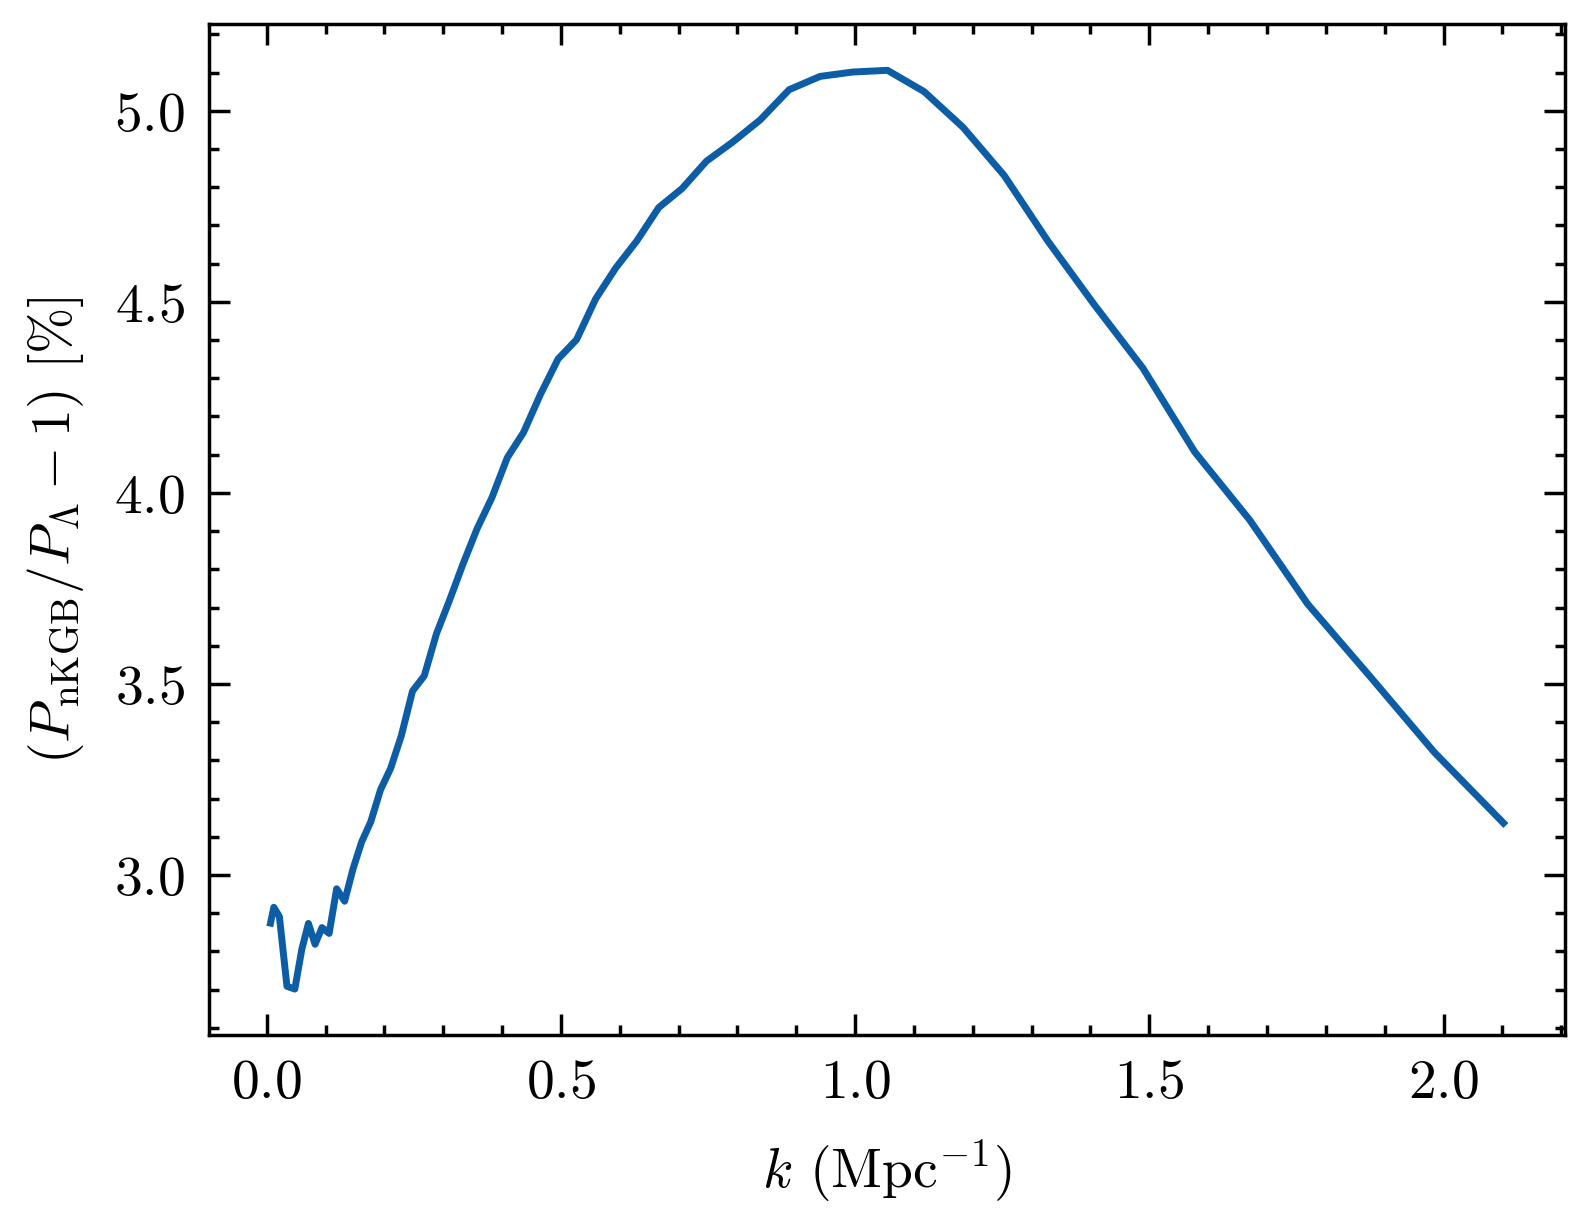

In [ ]:
compare_models(['hiLambda', 'nKGB'])

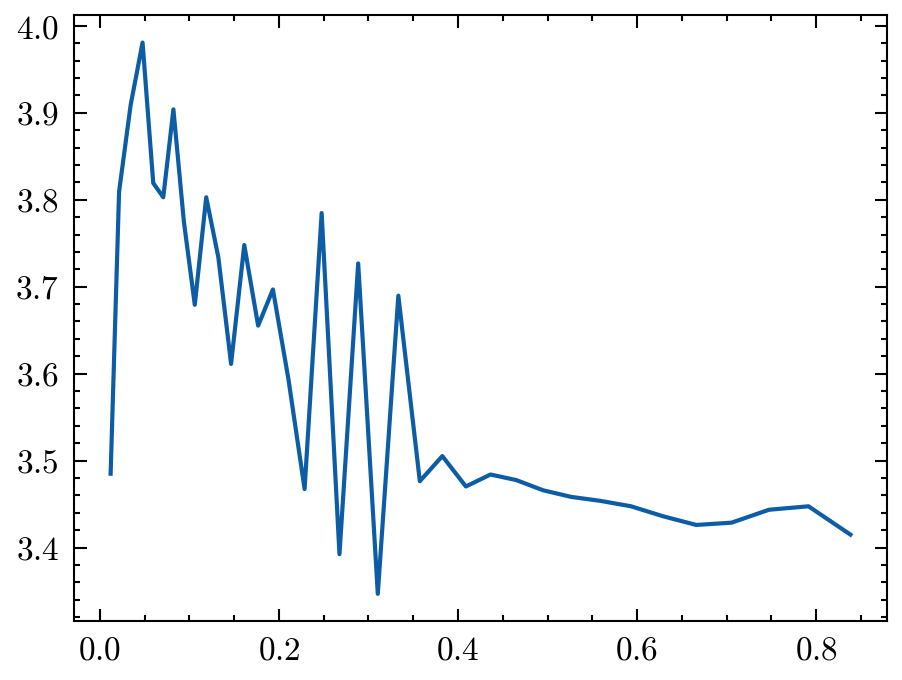

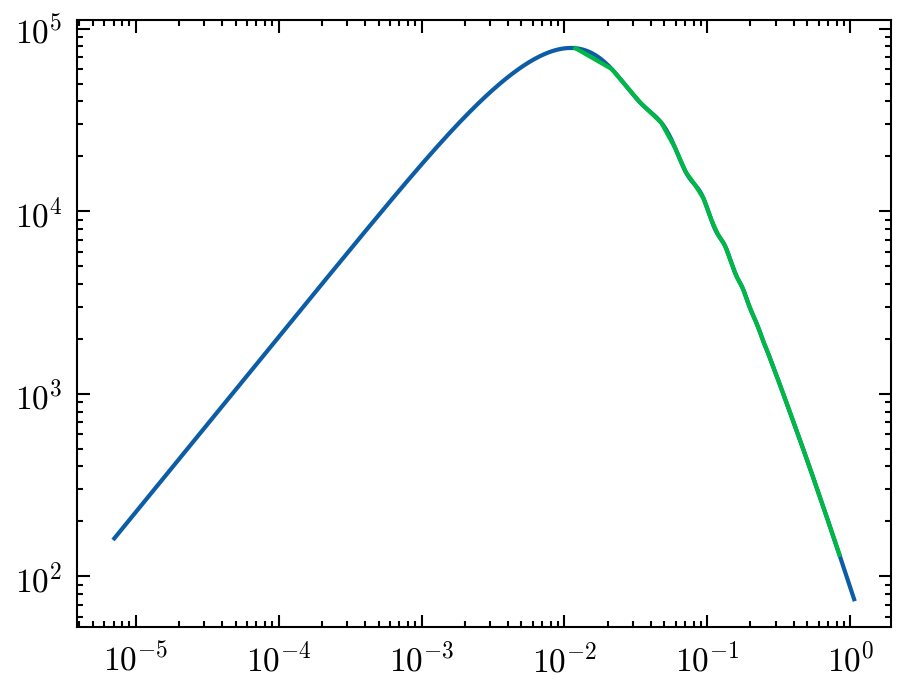

In [ ]:
compare_2_class('Lambda', 'output/class/lcdm00_pk_cb.dat')

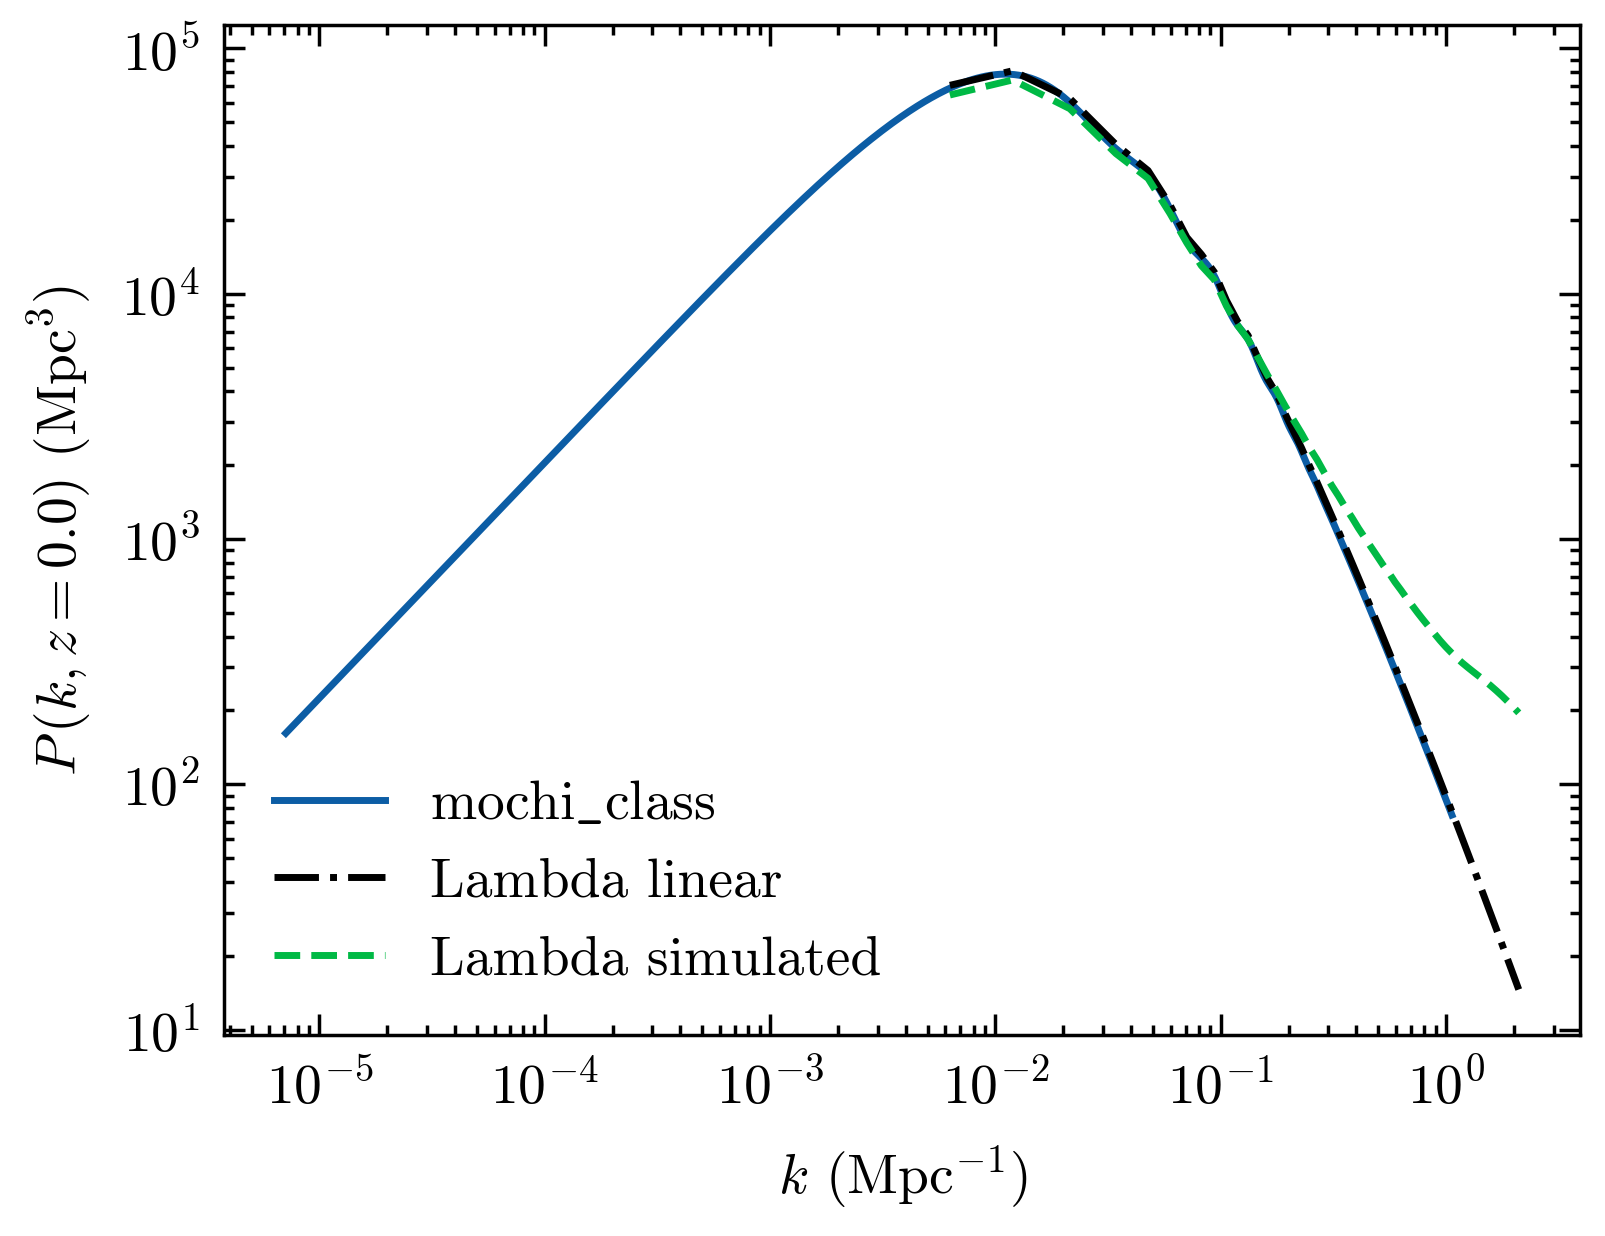

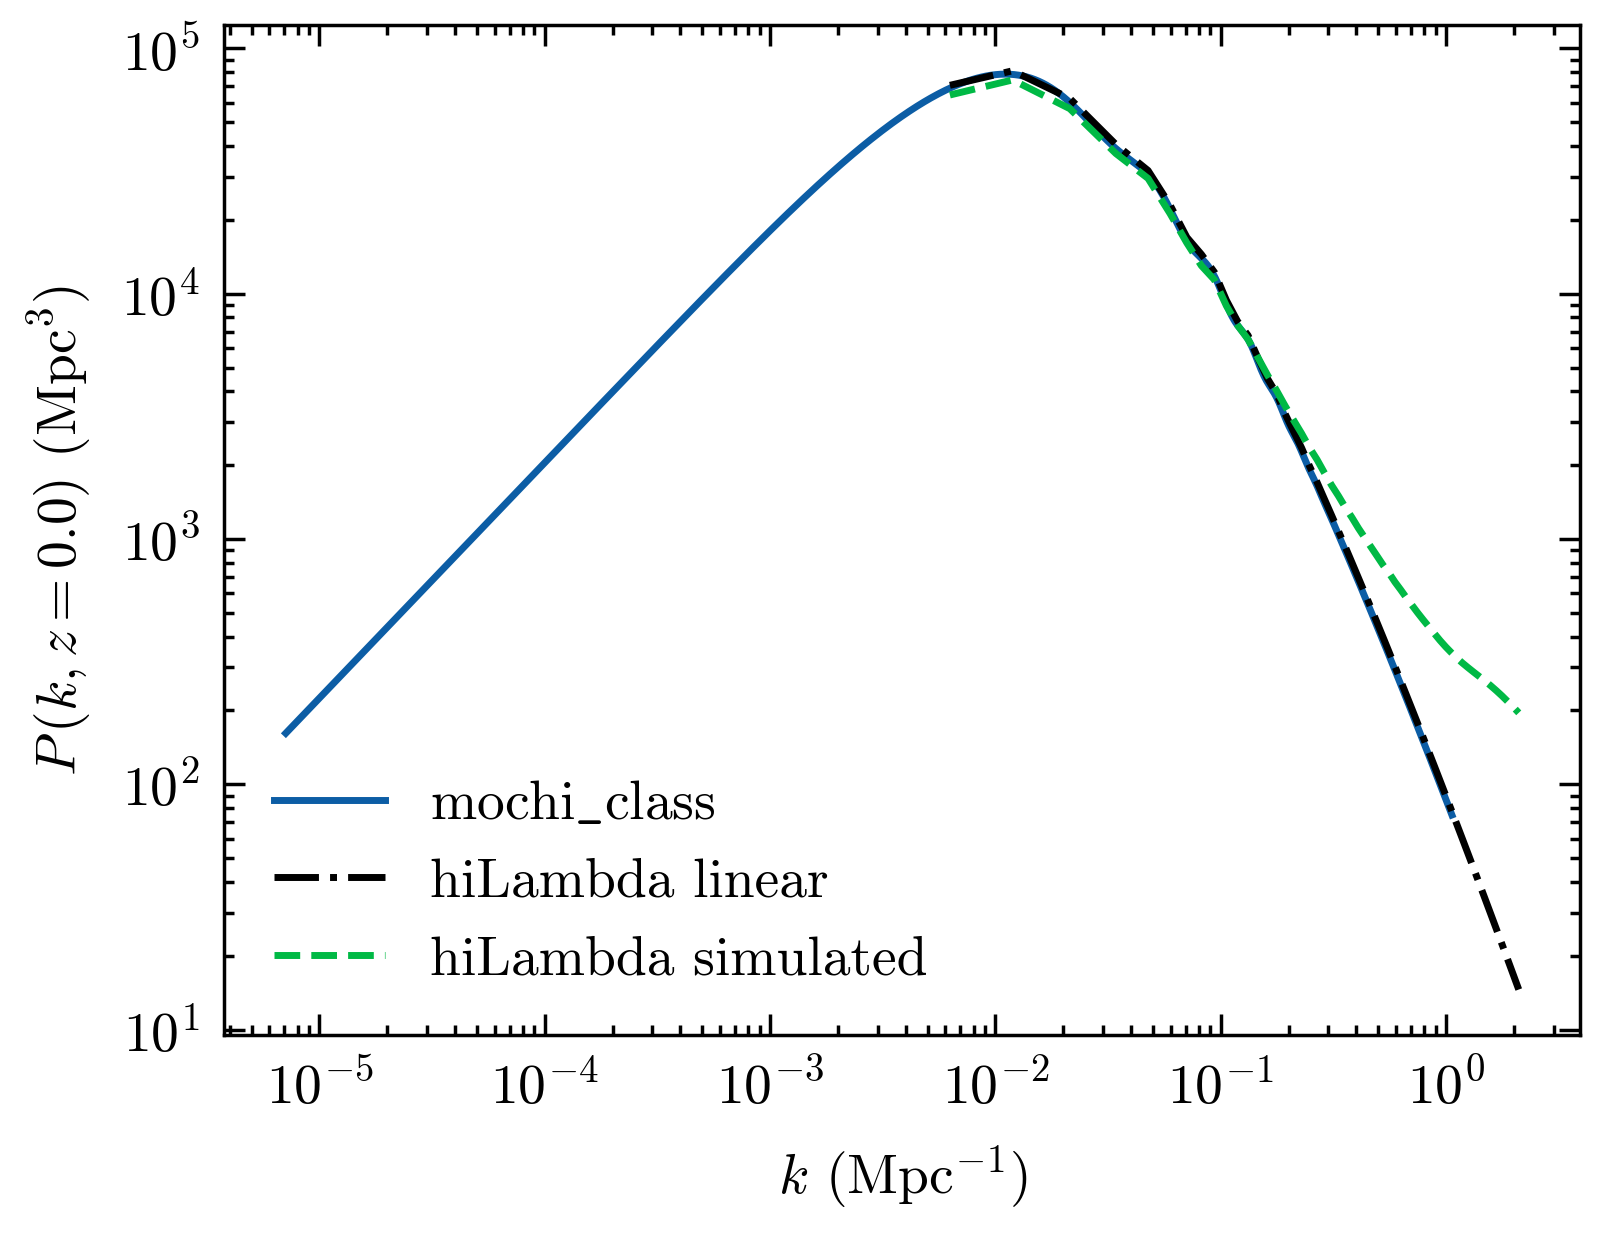

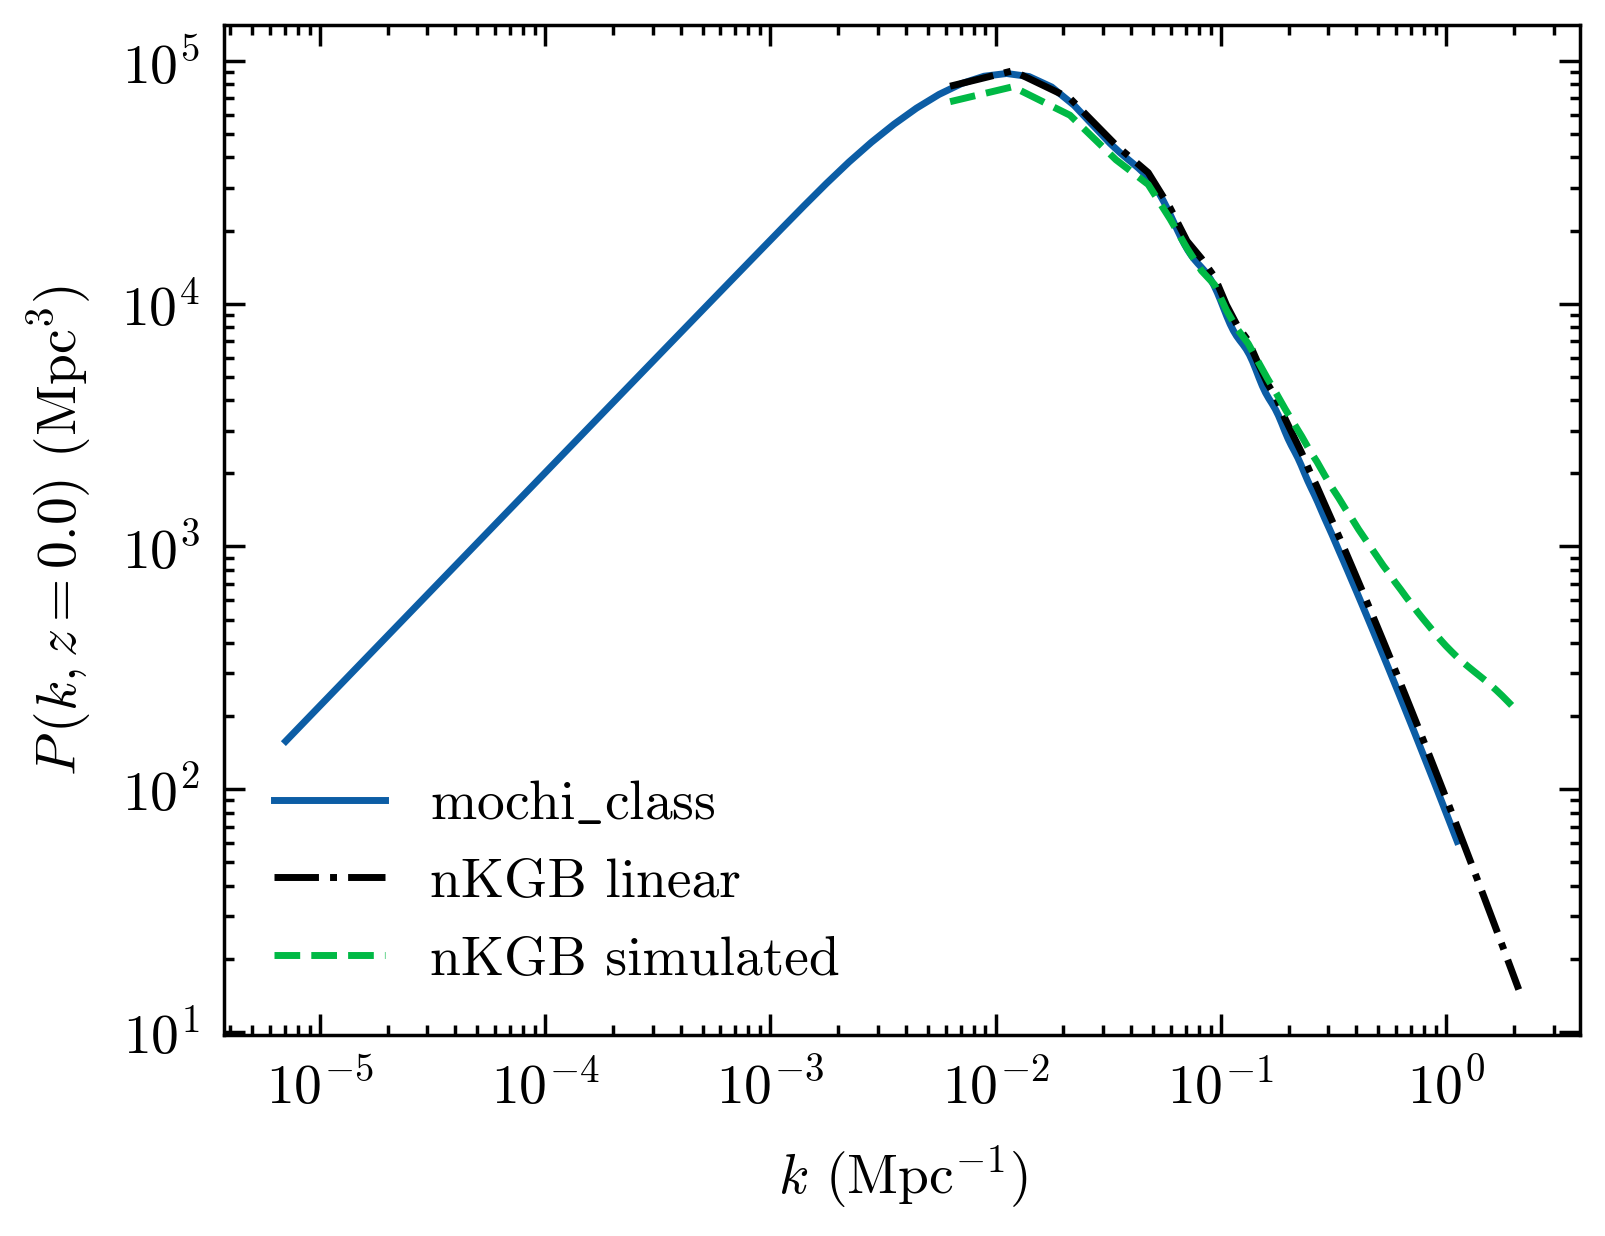

In [ ]:
plot_sim_vs_class('Lambda', 'output/class/lcdm00_pk_cb.dat')
plot_sim_vs_class('hiLambda', 'output/class/hilcdm00_pk_cb.dat')
plot_sim_vs_class('nKGB', 'output/class/nkgb00_pk_cb.dat')

ValueError: operands could not be broadcast together with shapes (54,) (526,) 

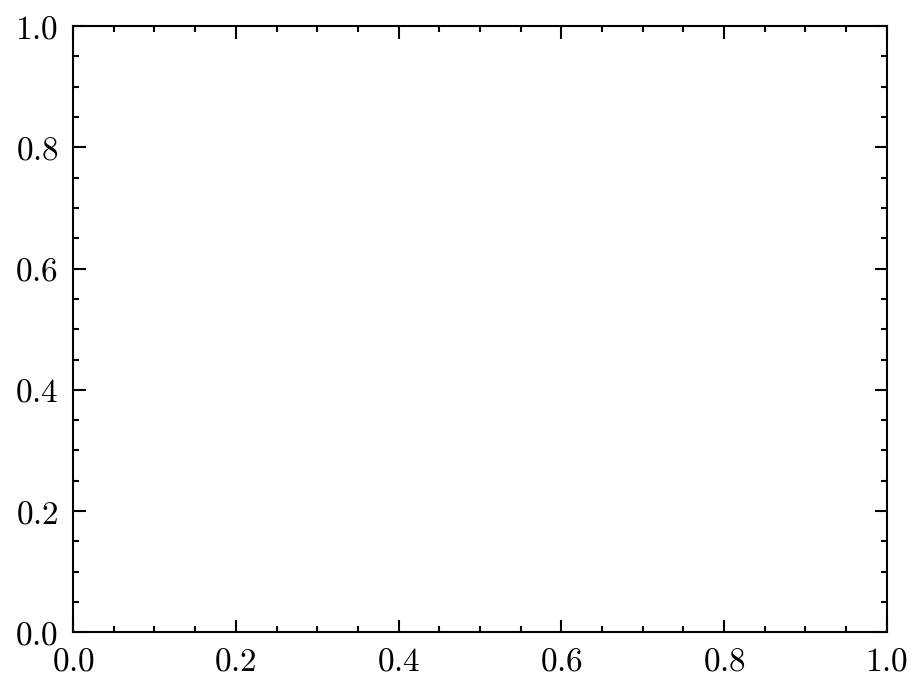

In [ ]:
plot_simtoclass('Lambda', 'output/class/lcdm00_pk_cb.dat')

In [ ]:
# Read simulation data
model = 'hiLambda'

ks['mochiclass'] = mochi_class._read_data()[0][model, 'a=1.00']
P_c['mochiclass']  = mochi_class._read_data()[1][model, 'a=1.00']
P_l['mochiclass']  = mochi_class._read_data()[2][model, 'a=1.00']
s8_c['mochiclass']  = mochi_class._read_data()[3][model, 'a=1.00']
s8_l['mochiclass']  = mochi_class._read_data()[4][model, 'a=1.00']

# Read data from CLASS
data = np.loadtxt("output/class/lcdm00_pk_cb.dat")

ks_class, pk_class = data[:,0], data[:,1]

ks_class *= .67
pk_class /= .67**3

In [ ]:
def plot_model(model, scale_factor=1):
    fig, ax = plt.subplots()
    normalization = (s8_l['mochiclass'] / s8_c['mochiclass'])**2

    ax.loglog(ks_class, pk_class, label='mochiclass')
    ax.plot(mochi_class._read_data()[0]['Lambda', 'a=1.00'], mochi_class._read_data()[2]['Lambda', 'a=1.00'], 'k-.', label='Lambda' + ' linear')
    # ax.plot(mochi_class._read_data()[0]['hiLambda', 'a=1.00'], mochi_class._read_data()[2]['hiLambda', 'a=1.00'], '--', label='hiLambda' + ' linear')
    ax.plot(mochi_class._read_data()[0]['Lambda', 'a=1.00'], normalization*mochi_class._read_data()[1]['Lambda', 'a=1.00'], '--', label='hiLambda' + ' simulation')
    # ax.plot(mochi_class._read_data()[0]['hiLambda', 'a=1.00'], mochi_class._read_data()[1]['hiLambda', 'a=1.00'], '--', label='hiLambda' + ' simulation')

    ax.set_ylabel(r'$P\,(k,z={:.1f})$ (Mpc$^{{3}}$)'.format(1/scale_factor - 1))
    ax.set_xlabel(r'$k$ (Mpc$^{-1}$)')
    ax.legend()

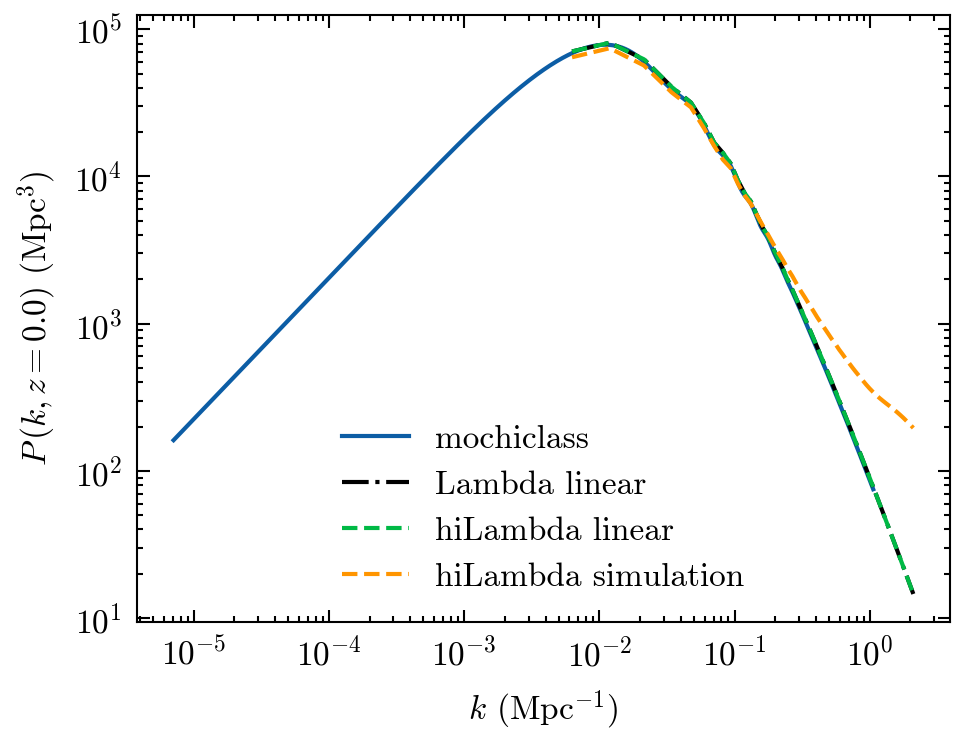

In [ ]:
scale_factor = 1

fig, ax = plt.subplots()
normalization = (s8_l['mochiclass'] / s8_c['mochiclass'])**2

ax.loglog(ks_class, pk_class, label='mochiclass')
ax.plot(mochi_class._read_data()[0]['Lambda', 'a=1.00'], mochi_class._read_data()[2]['Lambda', 'a=1.00'], 'k-.', label='Lambda' + ' linear')
# ax.plot(mochi_class._read_data()[0]['hiLambda', 'a=1.00'], mochi_class._read_data()[2]['hiLambda', 'a=1.00'], '--', label='hiLambda' + ' linear')
ax.plot(mochi_class._read_data()[0]['Lambda', 'a=1.00'], normalization*mochi_class._read_data()[1]['Lambda', 'a=1.00'], '--', label='hiLambda' + ' simulation')
# ax.plot(mochi_class._read_data()[0]['hiLambda', 'a=1.00'], mochi_class._read_data()[1]['hiLambda', 'a=1.00'], '--', label='hiLambda' + ' simulation')

ax.set_ylabel(r'$P\,(k,z={:.1f})$ (Mpc$^{{3}}$)'.format(1/scale_factor - 1))
ax.set_xlabel(r'$k$ (Mpc$^{-1}$)')
ax.legend()

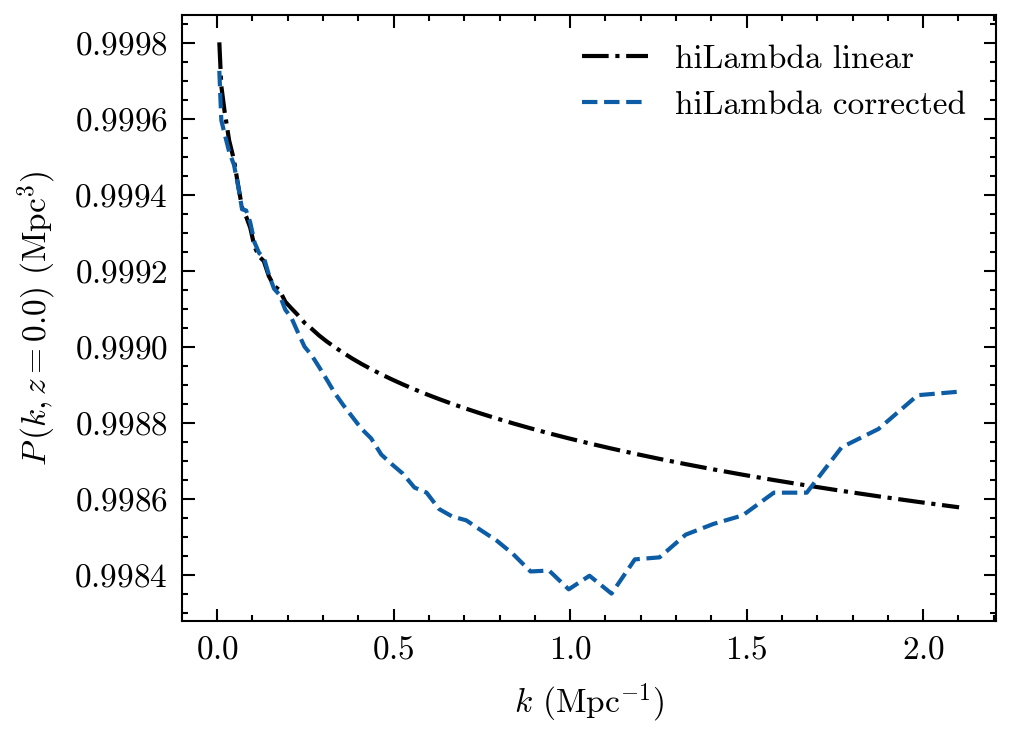

In [ ]:
scale_factor = 1

fig, ax = plt.subplots()
normalization = (s8_l['hiclass'] / s8_c['hiclass'])**2

ax.plot(mochi_class._read_data()[0][model, 'a=1.00'], np.sqrt(mochi_class._read_data()[2]['Lambda', 'a=1.00']/hi_class._read_data()[2]['Lambda', 'a=1.00']), 'k-.', label=model + ' linear')
ax.plot(mochi_class._read_data()[0][model, 'a=1.00'], np.sqrt(mochi_class._read_data()[1]['Lambda', 'a=1.00']/hi_class._read_data()[1]['Lambda', 'a=1.00']), '--', label=model + ' corrected')
ax.set_ylabel(r'$P\,(k,z={:.1f})$ (Mpc$^{{3}}$)'.format(1/scale_factor - 1))
ax.set_xlabel(r'$k$ (Mpc$^{-1}$)')
ax.legend()

In [ ]:
this_dir = os.getcwd() 

# Dictionaries to store power spectra and sigma_8 values
k, P_sims, P_corr, P_lins = {}, {}, {}, {}
sigma8_sims, sigma8_corr, sigma8_lins = {}, {}, {}

for filename in sorted(glob.glob(f'{this_dir}/output/hiLCDM/powerspec*'), key=os.path.getmtime):
    scale_factor = filename[-6:]
    matches = re.findall(r'(?=_(.*?)=(.*?)_)', os.path.basename(filename))
    
    if not matches or filename.endswith('.png'):
        continue

    for var, val in matches:
        exec(f'{var} = {val}')

    # Read file contents
    with open(filename, "r") as f:
        lines = f.readlines()

    # Extract sigma8 values
    sigma8_values = None
    for line in lines:
        if re.search(r"σ₈\s*=", line):  # Find the line containing σ₈ values
            sigma8_values = re.findall(r"[\d\.e\+\-]+", line)  # Extract numerical values
            sigma8_values = list(map(float, sigma8_values))  # Convert to floats
            break  # Stop searching once found

    # Read the power spectrum data
    k_, P_sim, P_c, P_lin = np.loadtxt(filename, usecols=(0,2,3,4), unpack=True)
    
    # Apply mask to remove NaNs
    mask = ~np.isnan(P_lin)
    P_sims[de, nunonlin, scale_factor] = P_sim[mask]
    P_corr[de, nunonlin, scale_factor] = P_c[mask]
    P_lins[de, scale_factor] = P_lin[mask]
    k[de, scale_factor] = k_[mask]

    # Store the sigma8 values
    if sigma8_values:
        sigma8_sims[de, nunonlin, scale_factor] = sigma8_values[0]  # First σ₈ (sim)
        sigma8_corr[de, nunonlin, scale_factor] = sigma8_values[1]  # Second σ₈ (corr)
        sigma8_lins[de, scale_factor] = sigma8_values[2]  # Third σ₈ (lin)

In [ ]:
k_class, P_class = {}, {}

class_files = {
    "Lambda": "/home/vpedre/concept_basem/dep/class/output/concept_lcdm00_pk.dat",
    "gal3": "/home/vpedre/concept_basem/dep/class/output/concept_gal300_pk.dat",
    "gal4": "/home/vpedre/concept_basem/dep/class/output/concept_gal400_pk.dat",
    "gal5": "/home/vpedre/concept_basem/dep/class/output/concept_gal500_pk.dat",
    "nKGB": "/home/vpedre/concept_basem/dep/class/output/concept_nkgb00_pk.dat",
}

for model, filepath in class_files.items():
    k_values, P_values = np.loadtxt(filepath, usecols=(0,1), unpack=True)
    k_class[model] = k_values
    P_class[model] = P_values


In [ ]:
k['Lambda', 'a=1.00']/0.67

array([0.00937789, 0.01779405, 0.03191272, 0.05113748, 0.07103843,
       0.08887595, 0.10559238, 0.12247262, 0.13997108, 0.15811791,
       0.17718681, 0.19739939, 0.21865069, 0.24063334, 0.2637511 ,
       0.28840119, 0.31414691, 0.34121333, 0.36964561, 0.39937725,
       0.43057679, 0.46327361, 0.49753007, 0.53334727, 0.57087464,
       0.61013872, 0.65120175, 0.69408854, 0.73888873, 0.78572812,
       0.83455399, 0.88546473, 0.93859737, 0.99430087, 1.05315354,
       1.1154616 , 1.1814274 , 1.25127866, 1.3252357 , 1.40358831,
       1.48660364, 1.57451925, 1.66760254, 1.76622164, 1.87064776,
       1.98124433, 2.09839925, 2.22246388, 2.35384493, 2.49302657,
       2.64045597, 2.79657254, 2.96191254, 3.13713806])

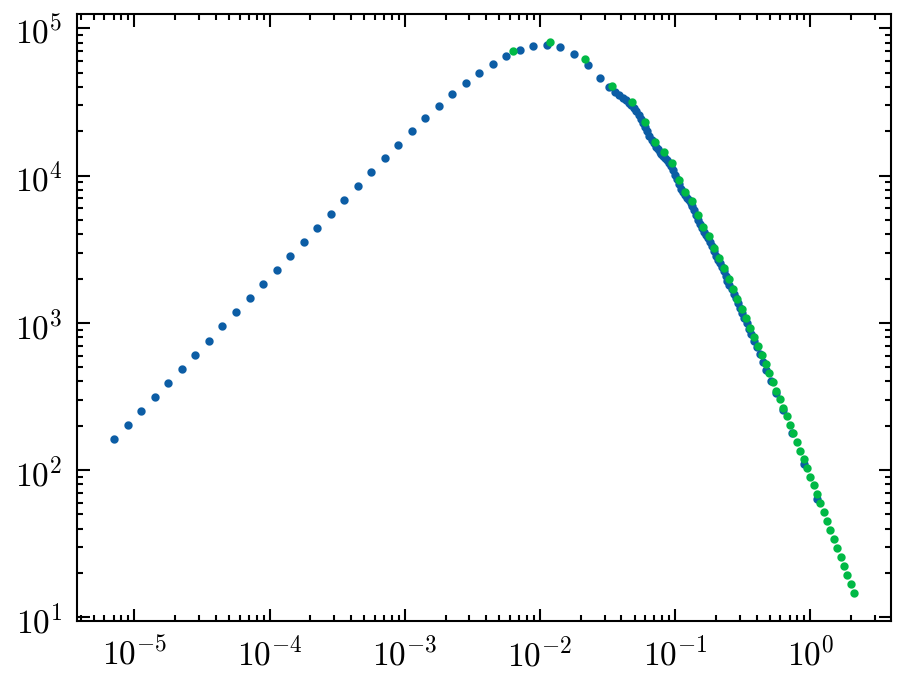

In [ ]:
fig, ax = plt.subplots()

ax.loglog(k_class['Lambda'] * 0.67, P_class['Lambda']/0.67**3, '.',ms=2)
ax.loglog(k['Lambda', 'a=1.00'], P_lins['Lambda', 'a=1.00'], '.',ms=2)

In [ ]:
def compare_2_class(model):
    ks_class = k_class[model] * 0.67
    Pk_class = P_class[model] / 0.67**3
    Pk_sim = P_lins[model, 'a=1.00']
    k_min, k_max = np.min(k[model, 'a=1.00']), np.max(k[model, 'a=1.00'])
    mask_min = k_class['Lambda'] > k_min
    mask_max = k_class['Lambda'] < k_max
    
    ks_class = ks_class[mask_min & mask_max]
    Pk_class = Pk_class[mask_min & mask_max]

    Pk_class = interp1d(ks_class, Pk_class, kind='spline', bounds_error=False, fill_value="extrapolate")
    fig, ax = plt.subplots()

    ax.plot(k[model, 'a=1.00'], np.abs(Pk_class(k[model, 'a=1.00']) - Pk_sim))
    # ax.loglog(k[model, 'a=1.00'], Pk_class(k[model, 'a=1.00']), '.', ms=2)
    # ax.loglog(k[model, 'a=1.00'], Pk_sim, '.', ms=2)

In [ ]:
compare_2_class('Lambda')

NameError: name 'k_class' is not defined

In [ ]:
k_min = np.min(k['Lambda', 'a=1.00'])
k_max = np.max(k['Lambda', 'a=1.00'])

mask_min = k_class['Lambda'] > k_min
mask_max = k_class['Lambda'] < k_max



In [ ]:
k_class['Lambda'][mask_min & mask_min]

In [ ]:
def plot_Pk(models, scale_factor=1, nunonlin=False, norm=True, class_pred=False, h=0.67):
    fig, ax = plt.subplots()
    if type(models) == str:
        models = [models]

    for model in models:
        if class_pred:
            ax.loglog(k_class[model]*h, P_class[model]/h**3, 'k-.', label= model+r' hi$\_$class')
        normalization=1
        if norm:
            normalization = (sigma8_lins[model, 'a=1.00']/sigma8_corr[model, nunonlin, 'a=1.00'])**2

        ax.loglog(k[model, f'a={scale_factor:.2f}'], P_lins[model, f'a={scale_factor:.2f}'], '--', label=model+' linear')
        ax.loglog(k[model, f'a={scale_factor:.2f}'], normalization*P_corr[model, nunonlin, f'a={scale_factor:.2f}'], label=model+' corrected')




    ax.set_ylabel(r'$P\,(k,z={:.1f})$ (Mpc$^{{3}}$)'.format(1/scale_factor - 1))
    ax.set_xlabel(r'$k$ (Mpc$^{-1}$)')
    ax.set_xlim(np.min(k[model, f'a={scale_factor:.2f}']))
    ax.legend()

In [ ]:
plot_Pk(['gal3'], class_pred=True)

In [ ]:
scale_factor = 1

fig, ax = plt.subplots()

norm = True

normalization_lcdm = 1
normalization_nkgb = 1
normalization_gal3 = 1
normalization_gal4 = 1

if norm:
    normalization_lcdm = (sigma8_lins['Lambda', 'a=1.00']/sigma8_corr['Lambda', False, 'a=1.00'])**2
    normalization_nkgb = (sigma8_lins['nKGB', 'a=1.00']/sigma8_corr['nKGB', False, 'a=1.00'])**2
    normalization_gal3 = (sigma8_lins['galileon3', 'a=1.00']/sigma8_corr['galileon3', False, 'a=1.00'])**2
    normalization_gal4 = (sigma8_lins['galileon4', 'a=1.00']/sigma8_corr['galileon4', False, 'a=1.00'])**2

# ax.loglog(k['nKGB', f'a={scale_factor:.2f}'], P_lins['nKGB', f'a={scale_factor:.2f}'], 'k-.', label=r'Linear')
# ax.loglog(k['nKGB', f'a={scale_factor:.2f}'], normalization*P_sims['nKGB', False, f'a={scale_factor:.2f}'], '.', ms=2, label=r'sim')
ax.loglog(k['nKGB', f'a={scale_factor:.2f}'], normalization_nkgb*P_corr['nKGB', False, f'a={scale_factor:.2f}'], '--', ms=2, label=r'nKGB')
ax.loglog(k['Lambda', f'a={scale_factor:.2f}'], normalization_lcdm*P_corr['Lambda', False, f'a={scale_factor:.2f}'], '--', ms=2, label=r'$\Lambda$')
ax.loglog(k['galileon3', f'a={scale_factor:.2f}'], normalization_gal3*P_corr['galileon3', False, f'a={scale_factor:.2f}'], '--', ms=2, label=r'gal3')
ax.loglog(k['galileon4', f'a={scale_factor:.2f}'], normalization_gal4*P_corr['galileon4', False, f'a={scale_factor:.2f}'], '--', ms=2, label=r'gal4')

# ax.loglog(k['nKGB', f'a={scale_factor:.2f}'], P_lins['nKGB', f'a={scale_factor:.2f}'], '--', ms=2, label=r'nKGB')
# ax.loglog(k['Lambda', f'a={scale_factor:.2f}'], P_lins['Lambda', f'a={scale_factor:.2f}'], '--', ms=2, label=r'$\Lambda$')
# ax.loglog(k['galileon3', f'a={scale_factor:.2f}ax.set_ylabel(r'$P\,(k,z={:.1f})$ (Mpc$^{{3}}$)'.format(1/scale_factor - 1))
ax.set_xlabel(r'$k$ (Mpc$^{-1}$)')'], P_lins['galileon3', f'a={scale_factor:.2f}'], '--', ms=2, label=r'gal3')
# ax.loglog(k['galileon4', f'a={scale_factor:.2f}'], P_lins['galileon4', f'a={scale_factor:.2f}'], '--', ms=2, label=r'gal4')

# hi-CLASS
# ax.loglog(k_class_lcdm * 0.67, P_class_lcdm / 0.67**3, label='hiclass')
# ax.loglog(k_hiclass_lcdm * 0.67, P_hiclass_lcdm / 0.67**3, label='hiclass')

ax.set_ylabel(r'$P\,(k,z={:.1f})$ (Mpc$^{{3}}$)'.format(1/scale_factor - 1))
ax.set_xlabel(r'$k$ (Mpc$^{-1}$)')
ax.set_title(r'$\Lambda$CDM vs nKGB')
ax.legend()

In [ ]:
scale_factor = 1

fig, ax = plt.subplots()

norm = True

normalization_lcdm = 1
normalization_nkgb = 1

if norm:
    normalization_lcdm = (sigma8_lins['Lambda', 'a=1.00']/sigma8_corr['Lambda', False, 'a=1.00'])**2
    normalization_nkgb = (sigma8_lins['nKGB', 'a=1.00']/sigma8_corr['nKGB', False, 'a=1.00'])**2
    

# ax.loglog(k['nKGB', f'a={scale_factor:.2f}'], P_lins['nKGB', f'a={scale_factor:.2f}'], 'k-.', label=r'Linear')
# ax.loglog(k['nKGB', f'a={scale_factor:.2f}'], normalization*P_sims['nKGB', False, f'a={scale_factor:.2f}'], '.', ms=2, label=r'sim')
ax.loglog(k['nKGB', f'a={scale_factor:.2f}'], normalization_nkgb*P_corr['nKGB', False, f'a={scale_factor:.2f}'], '--', ms=2, label=r'Corrected')
ax.loglog(k['nKGB', f'a={scale_factor:.2f}'], normalization_lcdm*P_corr['Lambda', False, f'a={scale_factor:.2f}'], '--', ms=2, label=r'Corrected')



# hi-CLASS
# ax.loglog(k_class_lcdm * 0.67, P_class_lcdm / 0.67**3, label='hiclass')
# ax.loglog(k_hiclass_lcdm * 0.67, P_hiclass_lcdm / 0.67**3, label='hiclass')

ax.set_ylabel(r'$P\,(k,z={:.1f})$ (Mpc$^{{3}}$)'.format(1/scale_factor - 1))
ax.set_xlabel(r'$k$ (Mpc$^{-1}$)')
ax.set_title(r'$\Lambda$CDM vs nKGB')
ax.legend()

In [ ]:
def window(k,R=8):
    kR =k*R
    term = np.sin(kR) / kR - np.cos(kR)
    output = 3/kR**2 * term
    return output

def sigma8(pk):
    # k_min, k_max = np.logspace(lin_k[0], lin_k[-1])
    integrand = lambda lk: np.exp(3 * lk) * pk(np.exp(lk)) * window(np.exp(lk))**2
    integral, _ = quad(integrand, np.log(lin_k[0]), np.log(lin_k[-1]), limit=200)
    return integral / (2 * np.pi**2) 
    
def normalize_Pk(Pk):
    norm = sigma8(Pk)

In [ ]:
s8_lin, s8_hi = sigma8(linPk_interpolated), sigma8(hiPk_interpolated)

In [ ]:
normalization = s8_lin/s8_hi

In [ ]:
np.sqrt(s8_lin)